## Apply all imports here

In [1]:
from os import listdir, getcwd
import os
from os.path import isfile, join
import subprocess
import sys
import csv
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import ast
import re
import json
import statistics
import numpy as np


## Read all csv files 

In [2]:
mypath_soot = join(getcwd(), 'eval_results/soot_res')
mypath_sootup = join(getcwd(), 'eval_results/sootup_res')
# print(mypath)

csv_files_soot = [f for f in listdir(mypath_soot) if isfile(join(mypath_soot, f))]
csv_files_sootup = [f for f in listdir(mypath_sootup) if isfile(join(mypath_sootup, f))]
print(csv_files_soot)
print(csv_files_sootup)

# csv_files_soot = ['soot_ide_eval_vm_merged.csv']
# csv_files_sootup = ['sootUp_ide_eval_mix_vm_1.csv']
# csv_files_soot = ['convert_soot_commatosemicolon.csv']
csv_files_soot = ['soot_ide_eval_mix_vm_individualbt.csv']
csv_files_sootup = ['sootUp_ide_eval_mix_vm_individualbi.csv']


completepaths_soot = [os.path.join(mypath_soot, f) for f in csv_files_soot]
completepaths_sootup = [os.path.join(mypath_sootup, f) for f in csv_files_sootup]
# print(completepaths)

desired_col_soot = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI","BodyTransformers","BodyTransformersMetrics"]
desired_col_sootup = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI","BodyInterceptors","BodyInterceptorsMetrics"]

for completefilepath_soot in completepaths_soot:
    df_soot = pd.read_csv(completefilepath_soot, sep=";")

for completefilepath_sootup in completepaths_sootup:
    df_sootup = pd.read_csv(completefilepath_sootup, sep=";")

df_soot.columns = desired_col_soot
df_sootup.columns = desired_col_sootup


def apply_complex_function1(x):
    return list(map(str.strip, x['BodyTransformers'].strip('[]').split(',')))

def apply_complex_function2(x):
    return list(map(str.strip, x['BodyInterceptors'].strip('[]').split(',')))

def convert_to_dict1(metric_str):
    metric_str['BodyTransformersMetrics'] = re.sub(r'(\b[\w.-]+\b)(?=\s*=\s*\[)', r'"\1"', metric_str['BodyTransformersMetrics'])  # Quote keys
    metric_str['BodyTransformersMetrics'] = metric_str['BodyTransformersMetrics'].replace('=', ':').replace('[', '[').replace(']', ']')
    return json.loads(metric_str['BodyTransformersMetrics'].replace("'", '"'))

def convert_to_dict2(metric_str):
    # Replace '=' with ':' and add double quotes around the keys
    metric_str['BodyInterceptorsMetrics'] = re.sub(r'@[\w]+', '', metric_str['BodyInterceptorsMetrics'])
    metric_str['BodyInterceptorsMetrics'] = re.sub(r'([\w\.]+)=', r'"\1":', metric_str['BodyInterceptorsMetrics'])
    metric_str['BodyInterceptorsMetrics'] = metric_str['BodyInterceptorsMetrics'].replace('=', ':').replace('[', '[').replace(']', ']')
    return json.loads(metric_str['BodyInterceptorsMetrics'].replace("'", '"'))

key_mapping = {
    'sootup.interceptors.TypeAssigner': 'jb.tr',
    'sootup.interceptors.DeadAssignmentEliminator': 'jb.dae',
    'sootup.interceptors.UnusedLocalEliminator': 'jb.ule',
    'sootup.interceptors.LocalSplitter': 'jb.ls',
    'sootup.interceptors.LocalPacker': 'jb.lp',
    'sootup.interceptors.CopyPropagator': 'jb.cp',
    'sootup.interceptors.Aggregator': 'jb.a',
    'sootup.interceptors.EmptySwitchEliminator': 'jb.ese',
    'sootup.interceptors.ConditionalBranchFolder': 'jb.cbf',
    'sootup.interceptors.NopEliminator': 'jb.ne',
    'sootup.interceptors.LocalNameStandardizer': 'jb.lns',
    'sootup.interceptors.UnreachableCodeEliminator': 'jb.uce'
}

def replace_keys_in_dict(original_dict):
    new_dict = {}
    for old_key, value in original_dict['BodyInterceptorsMetrics'].items():
        # Use the mapping to replace the key if it exists in the mapping
        new_key = key_mapping.get(old_key, old_key)  # If not in mapping, keep original key
        new_dict[new_key] = value
    return new_dict
    
df_soot['BodyTransformers'] = df_soot.apply(apply_complex_function1, axis=1)
df_sootup['BodyInterceptors'] = df_sootup.apply(apply_complex_function2, axis=1)
df_soot['BodyTransformersMetrics'] = df_soot.apply(convert_to_dict1, axis=1)
df_sootup['BodyInterceptorsMetrics'] = df_sootup.apply(convert_to_dict2, axis=1)
df_sootup['BodyInterceptorsMetrics'] = df_sootup.apply(replace_keys_in_dict, axis=1)


df_soot['stmtCountAfterApplyingBI'] = pd.to_numeric(df_soot['stmtCountAfterApplyingBI'], errors='coerce')
df_soot['initialStmtCount'] = pd.to_numeric(df_soot['initialStmtCount'], errors='coerce')
df_soot['totalRuntime'] = pd.to_numeric(df_soot['totalRuntime'], errors='coerce')
df_soot['cgConstructionTime'] = pd.to_numeric(df_soot['cgConstructionTime'], errors='coerce')
df_soot['prop'] = pd.to_numeric(df_soot['prop'], errors='coerce')
df_soot['method'] = pd.to_numeric(df_soot['method'], errors='coerce')
df_soot['callGraphEdges'] = pd.to_numeric(df_soot['callGraphEdges'], errors='coerce')
df_soot['callGraphReachableNodes'] = pd.to_numeric(df_soot['callGraphReachableNodes'], errors='coerce')


df_sootup['stmtCountAfterApplyingBI'] = pd.to_numeric(df_sootup['stmtCountAfterApplyingBI'], errors='coerce')
df_sootup['initialStmtCount'] = pd.to_numeric(df_sootup['initialStmtCount'], errors='coerce')
df_sootup['totalRuntime'] = pd.to_numeric(df_sootup['totalRuntime'], errors='coerce')
df_sootup['cgConstructionTime'] = pd.to_numeric(df_sootup['cgConstructionTime'], errors='coerce')
df_sootup['prop'] = pd.to_numeric(df_sootup['prop'], errors='coerce')
df_sootup['method'] = pd.to_numeric(df_sootup['method'], errors='coerce')
df_sootup['callGraphEdges'] = pd.to_numeric(df_sootup['callGraphEdges'], errors='coerce')
df_sootup['callGraphReachableNodes'] = pd.to_numeric(df_sootup['callGraphReachableNodes'], errors='coerce')


# df_soot['BodyTransformers'][1]
# df_soot['BodyTransformersMetrics'][1].keys()
# df_sootup['BodyInterceptors'][1]
# df_sootup['BodyInterceptorsMetrics'][1].keys()


['convert_soot_commatosemicolon.csv', 'soot_ide_eval_CHA_20_run1.csv', 'soot_ide_eval_CHA_20_run2_hp.csv', 'soot_ide_eval_mix_run3_hp.csv', 'soot_ide_eval_mix_vm_individualbt.csv', 'soot_ide_eval_RTA_17_run1.csv', 'soot_ide_eval_RTA_17_run2.csv', 'soot_ide_eval_vm_cha_1.csv', 'soot_ide_eval_vm_merged.csv', 'soot_ide_eval_vm_mix_1.csv', 'soot_ide_eval_vm_mix_2.csv', 'soot_ide_eval_vm_rta_1.csv']
['sootUp_ide_eval_CHA_13_run1.csv', 'sootUp_ide_eval_mix_vm_1.csv', 'sootUp_ide_eval_mix_vm_individualbi.csv', 'sootUp_ide_eval_RTA_13_run1.csv']


In [3]:
df_soot.iloc[0:1]

,jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,BodyTransformers,BodyTransformersMetrics
0,jsr305-3.0.2,default,1,3246,1092,0,0,46,CHA,155,100,475,0,"[JB_LS, JB_TR]","{'jb.tr': [135, 0], 'jb.ls': [192, 1]}"


In [4]:
df_sootup.iloc[0:1]

,jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,BodyInterceptors,BodyInterceptorsMetrics
0,jackson-core-2.14.2,default,1,16050,231,200613,50,311,CHA,12965,2859,46237,46542,"[JB_LS, JB_TR, JB_LP]","{'jb.ls': [139, 106], 'jb.lp': [425, 120], 'jb..."


In [ ]:
df.groupby('jar')['jar'].count()

## Convert csv with , files

In [7]:
import re
import json
import pandas as pd
import csv
import ast

mypath = join(getcwd(), 'eval_results/soot_res')
# print(mypath)

csv_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# print(csv_files)
csv_files = ['soot_ide_eval_CHA_20_run1.csv','soot_ide_eval_CHA_20_run2_hp.csv', 'soot_ide_eval_RTA_17_run1.csv', 'soot_ide_eval_RTA_17_run2.csv']
# csv_files = ['soot_ide_eval_CHA_20_run1.csv','soot_ide_eval_CHA_20_run2_hp.csv']

completepaths = [os.path.join(mypath, f) for f in csv_files]
print(completepaths)

all_lines = []
for completepath in completepaths:
    with open(completepath, 'r', encoding='UTF-8') as file:
        lines = [line.rstrip() for line in file]
        all_lines.extend(lines)

print(lines[1])

# input_str = """
# jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,BodyTransformers,BodyTransformersMetrics
# assertj-core-3.24.2,default,1,88422,5368,3974427,50,554,CHA,57910,13599,101912,102790,[JB_LS, JB_TR],{jb.tr=[1470, -366], jb.ls=[903, -50]}
# assertj-core-3.24.2,default,1,62110,6085,3020975,50,594,CHA,57910,13599,101912,102790,[JB_LS, JB_TR, JB_LP],{jb.tr=[1424, 2], jb.lp=[697, -126], jb.ls=[731, -476]}
# """
input_str = '\n'.join(all_lines)
# print(input_str)

new_ouput = ""
new_different_output = ""
for each_row in input_str.split('\n'): 
    # print(each_row)
    if each_row.strip() != "":
        split_row = each_row.split(',')
        new_ouput += ','.join(split_row[:13])
        new_ouput += '\n'
        new_different_output += ','.join(split_row[13:])
        new_different_output += '\n'

# with open('simple_output.csv', 'w') as file:
#     file.write(new_ouput)

# df = pd.read_csv('simple_output.csv')
# # print(df.head())

TESTDATA = StringIO(new_ouput)
df = pd.read_csv(TESTDATA, sep=",")

pattern = r'^(\[.*?\]),(\{.*\})$'

each_index = 0
for each_row in new_different_output.split('\n'):
    if each_row.strip() != "" and not each_row.startswith('BodyTransformers'):
        match = re.match(pattern, each_row)
        if match:
            BodyTransformers_str = match.group(1)
            df.loc[each_index, 'BodyTransformers'] = BodyTransformers_str
            column_z_str = match.group(2)
            df.loc[each_index, 'BodyTransformersMetrics'] = column_z_str
            # BodyTransformers_str = match.group(1)
            # column_y = BodyTransformers_str.strip('[]').split(',')
            # # print(each_index)
            # df.loc[each_index, 'BodyTransformers'] = json.dumps(column_y)
            # column_z_str = match.group(2).replace('=', ':')
            # # column_z_str = re.sub(r'([\w\.]+):', r'"\1":', column_z_str)
            # column_z_str = re.sub(r'([a-zA-Z0-9._-]+):', r'"\1":', column_z_str)
            # # string_literal = repr(column_z_str)
            # # print(column_z_str)
            # column_z = json.loads(column_z_str)
            # df.loc[each_index, 'BodyTransformersMetrics'] = json.dumps(column_z)
        each_index += 1

# print(df.head())

df.to_csv('convert_soot_commatosemicolon.csv', sep =';', index=False)

# with open('convert_soot_commatosemicolon.csv', 'w') as file:
#     file.write(new_ouput)

# df_CHA = df[df['CallGraphAlgo'] == 'CHA']
# df_RTA = df[df['CallGraphAlgo'] == 'RTA']
# print(f"df CHA rows: {len(df_CHA.index)} columns: {len(df_CHA.columns)}")
# print(f"df RTA rows: {len(df_RTA.index)} columns: {len(df_RTA.columns)}")

['C:\\Users\\sahil\\Documents\\master-thesis\\MSThesis\\eval_results/soot_res\\soot_ide_eval_CHA_20_run1.csv', 'C:\\Users\\sahil\\Documents\\master-thesis\\MSThesis\\eval_results/soot_res\\soot_ide_eval_CHA_20_run2_hp.csv', 'C:\\Users\\sahil\\Documents\\master-thesis\\MSThesis\\eval_results/soot_res\\soot_ide_eval_RTA_17_run1.csv', 'C:\\Users\\sahil\\Documents\\master-thesis\\MSThesis\\eval_results/soot_res\\soot_ide_eval_RTA_17_run2.csv']
commons-codec-1.15,default,1,8692,1575,398587,50,203,RTA,5907,1506,27940,24432,[JB_LS, JB_TR],{jb.tr=[347, 9], jb.ls=[206, -23]}


In [ ]:
for key, value in df_CHA['BodyTransformersMetrics'].items():
    None
    # print(value)

df_CHA.head(1)
df_CHA.describe

## Grouped data for CHA and RTA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


df_soot_analysis = pd.DataFrame({
    'jar': df_soot['jar'],
    'cgConstructionTime': df_soot['cgConstructionTime'],
    'CallGraphAlgo': df_soot['CallGraphAlgo'],
    'callGraphEdges': df_soot['callGraphEdges'],
    'callGraphReachableNodes': df_soot['callGraphReachableNodes'],
    'stmtDiff': df_soot['stmtCountAfterApplyingBI'] - df_soot['initialStmtCount'],
    'BodyTransformers': df_soot['BodyTransformers'],
    'BodyTransformersMetrics': df_soot['BodyTransformersMetrics']
})

df_sootup_analysis = pd.DataFrame({
    'jar': df_sootup['jar'],
    'cgConstructionTime': df_sootup['cgConstructionTime'],
    'CallGraphAlgo': df_sootup['CallGraphAlgo'],
    'callGraphEdges': df_sootup['callGraphEdges'],
    'callGraphReachableNodes': df_sootup['callGraphReachableNodes'],
    'stmtDiff': df_sootup['stmtCountAfterApplyingBI'] - df_sootup['initialStmtCount'],
    'BodyInterceptors': df_sootup['BodyInterceptors'],
    'BodyInterceptorsMetrics': df_sootup['BodyInterceptorsMetrics']
})

# Ensure that BodyTransformers column contains tuples
df_soot_analysis['BodyTransformers'] = df_soot_analysis['BodyTransformers'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_sootup_analysis['BodyInterceptors'] = df_sootup_analysis['BodyInterceptors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Function to sum the first value from each list in BodyInterceptorsMetrics
def calculate_bi_total_time(metrics):
    if isinstance(metrics, dict):  # Check if it's a dictionary
        total_time = sum(value[0] for key, value in metrics.items() if isinstance(value, list) and len(value) > 0)
        return total_time
    return 0  # Return 0 if BodyInterceptorsMetrics is not a dictionary or has no valid data

# Apply the function to create a new column 'BITotalTime'
df_soot_analysis['BITotalTime'] = df_soot_analysis['BodyTransformersMetrics'].apply(calculate_bi_total_time)
df_sootup_analysis['BITotalTime'] = df_sootup_analysis['BodyInterceptorsMetrics'].apply(calculate_bi_total_time)

# Group by (jar, BodyInterceptors) and aggregate the values
grouped_df_soot = df_soot_analysis.groupby(['jar', 'BodyTransformers'], as_index=False).agg({
    'BITotalTime': 'mean',  # Sum of BITotalTime for each group
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'stmtDiff': 'mean'
})

grouped_df_sootup = df_sootup_analysis.groupby(['jar', 'BodyInterceptors'], as_index=False).agg({
    'BITotalTime': 'mean',  # Sum of BITotalTime for each group
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'stmtDiff': 'mean'
})

# Display the resulting DataFrame
print(grouped_df_soot)
print(grouped_df_sootup)


In [11]:
setofjarsinsoot = set()
# iterate through specific columns of the dataframe
for index, row in df_soot_analysis.loc[:, ['jar','BodyTransformers']].iterrows():
    setofjarsinsoot.add(tuple(row['jar']))
    # print(row['callGraphEdges'], row['BodyInterceptors'])

print(len(setofjarsinsoot))

setofjarsinsootup = set()
# iterate through specific columns of the dataframe
for index, row in df_sootup_analysis.loc[:, ['jar','BodyInterceptors']].iterrows():
    setofjarsinsootup.add(tuple(row['jar']))
    # print(row['callGraphEdges'], row['BodyInterceptors'])

print(len(setofjarsinsootup))

17
14


# ===================== RQ2 ==========================

# IF YOU WANT TO COMPARE INDIVIDUAL BODY INTERCEPTOR THEN RUN WITH JUST INDIVIDUAL INTERCEPTOR but (jb.ls, jb,tr) mandatory

In [12]:
grouped_df_soot.iloc[0:1]

,jar,BodyTransformers,BITotalTime,cgConstructionTime,callGraphEdges,callGraphReachableNodes,stmtDiff
0,commons-codec-1.15,"(JB_LS, JB_TR)",2027.0,3925.666667,6558.5,1734.5,-3514.0


In [13]:
grouped_df_sootup.iloc[0:1]

,jar,BodyInterceptors,BITotalTime,cgConstructionTime,callGraphEdges,callGraphReachableNodes,stmtDiff
0,commons-codec-1.15,"(JB_LS, JB_TR)",1513.5,318.5,4349.5,1187.0,385.0


### Average of all jars Runtime

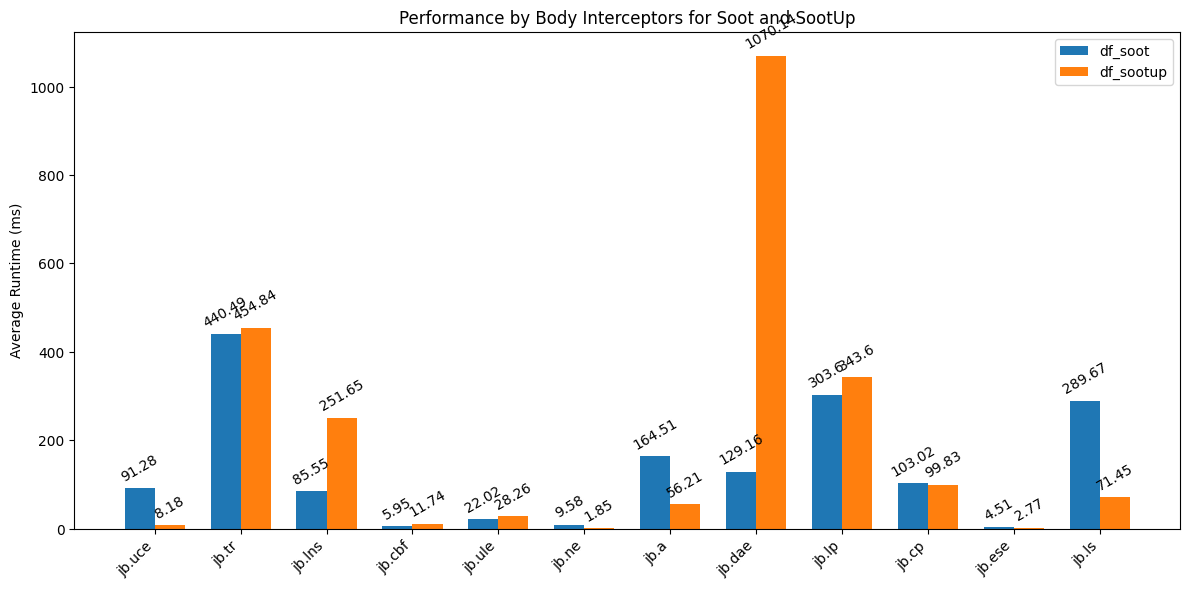

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample Data
df_soot = pd.DataFrame({
    'jar': df_soot['jar'],
    'BodyTransformers': df_soot['BodyTransformers'],
    'BodyTransformersMetrics': df_soot['BodyTransformersMetrics']
})

df_sootup = pd.DataFrame({
    'jar': df_sootup['jar'],
    'BodyInterceptors': df_sootup['BodyInterceptors'],
    'BodyInterceptorsMetrics': df_sootup['BodyInterceptorsMetrics']
})

# Extract the transformers and their performance metrics, skipping those with list size == 1
def extract_metrics1(df):
    metrics_soot_temp = {}
    for idx, row in df.iterrows():
        if len(row['BodyTransformersMetrics']) > 1:
            for transformer, values in row['BodyTransformersMetrics'].items():
                if transformer in metrics_soot_temp:
                    metrics_soot_temp[transformer].append(values[0])
                else:
                    metrics_soot_temp[transformer] = [values[0]]  # Assuming we take the first value as the performance metric
    return metrics_soot_temp

def extract_metrics2(df):
    metrics_sootup_temp = {}
    for idx, row in df.iterrows():
        if len(row['BodyInterceptorsMetrics']) > 1:
            for transformer, values in row['BodyInterceptorsMetrics'].items():
                # Appending each value as a list & later average it
                if transformer in metrics_sootup_temp:
                    metrics_sootup_temp[transformer].append(values[0])
                else:
                    metrics_sootup_temp[transformer] = [values[0]]  # Assuming we take the first value as the performance metric
    return metrics_sootup_temp

metrics_soot = extract_metrics1(df_soot)
metrics_sootup = extract_metrics2(df_sootup)

# Align the transformers for comparison
all_transformers = set(metrics_soot.keys()).union(set(metrics_sootup.keys()))
# print(all_transformers)

# Create lists for the metrics for each dataframe
# soot_values = [metrics_soot.get(transformer, 0) for transformer in all_transformers]
# sootup_values = [metrics_sootup.get(transformer, 0) for transformer in all_transformers]
soot_values = [round(statistics.fmean(metrics_soot.get(transformer)), 2) for transformer in all_transformers]
# for some reason list has None values (maybe in sootup we don't have uce values we call it with cbf)
sootup_values = [
    round(statistics.fmean([val for val in metrics_sootup.get(transformer, [0]) if val is not None]) , 2)
    for transformer in all_transformers
]

# Plotting side-by-side bar charts
x = np.arange(len(all_transformers))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, soot_values, width, label='df_soot')
rects2 = ax.bar(x + width/2, sootup_values, width, label='df_sootup')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Average Runtime (ms)')
ax.set_title('Performance by Body Interceptors for Soot and SootUp')
ax.set_xticks(x)
ax.set_xticklabels(all_transformers, rotation=45, ha='right')
ax.legend()

# Function to label the bars with their heights
def autolabel(rects):
    """Attach a text label above each bar in rects, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation = 30)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


### Individual Jar Runtime

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_runtime'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Sample Data
df_soot = pd.DataFrame({
    'jar': grouped_df_soot['jar'],
    'BodyTransformers': grouped_df_soot['BodyTransformers'],
    'BodyTransformersMetrics': grouped_df_soot['BodyTransformersMetrics']
})

df_sootup = pd.DataFrame({
    'jar': df_sootup['jar'],
    'BodyInterceptors': df_sootup['BodyInterceptors'],
    'BodyInterceptorsMetrics': df_sootup['BodyInterceptorsMetrics']
})

# Extract the transformers and their performance metrics, skipping those with list size == 1
def extract_metrics1(df):
    metrics_soot_temp = {}
    for idx, row in df.iterrows():
        if len(row['BodyTransformersMetrics']) > 1:
            for transformer, values in row['BodyTransformersMetrics'].items():
                if transformer in metrics_soot_temp:
                    metrics_soot_temp[transformer].append(values[0])
                else:
                    metrics_soot_temp[transformer] = [values[0]]  # Taking the first value as the performance metric
    return metrics_soot_temp

def extract_metrics2(df):
    metrics_sootup_temp = {}
    for idx, row in df.iterrows():
        if len(row['BodyInterceptorsMetrics']) > 1:
            for transformer, values in row['BodyInterceptorsMetrics'].items():
                if transformer in metrics_sootup_temp:
                    metrics_sootup_temp[transformer].append(values[0])
                else:
                    metrics_sootup_temp[transformer] = [values[0]]  # Taking the first value as the performance metric
    return metrics_sootup_temp

# Variable to count the number of times an interceptor takes more time in sootup than soot
interceptor_count = {}

# Loop through each unique jar
for jar in df_soot['jar'].unique():
    # Filter the data for the current jar
    df_soot_jar = df_soot[df_soot['jar'] == jar]
    df_sootup_jar = df_sootup[df_sootup['jar'] == jar]
    
    # Extract metrics for the jar-specific data
    metrics_soot = extract_metrics1(df_soot_jar)
    metrics_sootup = extract_metrics2(df_sootup_jar)

    # Align the transformers for comparison
    all_transformers = set(metrics_soot.keys()).union(set(metrics_sootup.keys()))
    
    # Create lists for the metrics for each dataframe
    soot_values = [round(statistics.fmean(metrics_soot.get(transformer, [0])), 2) for transformer in all_transformers]
    sootup_values = [
        round(statistics.fmean([val for val in metrics_sootup.get(transformer, [0]) if val is not None]), 2)
        for transformer in all_transformers
    ]

    # Compare the values and count where sootup takes more time than soot
    for i, transformer in enumerate(all_transformers):
        if sootup_values[i] > soot_values[i]:
            interceptor_count[transformer] = interceptor_count.get(transformer, 0) + 1

    # Plotting side-by-side bar charts for the specific jar
    x = np.arange(len(all_transformers))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, soot_values, width, label='df_soot')
    rects2 = ax.bar(x + width/2, sootup_values, width, label='df_sootup')

    # Add labels, title, and custom x-axis tick labels
    ax.set_ylabel('Average Runtime (ms)')
    ax.set_title(f'Performance by Body Interceptors for Soot and SootUp - {jar}')
    ax.set_xticks(x)
    ax.set_xticklabels(all_transformers, rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        rotation = 30)

    autolabel(rects1)
    autolabel(rects2)

    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    # Save the plot
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)


# Print the count of how many times each interceptor took more time in sootup than soot
print("Interceptor counts where sootup takes more time than soot:")
for interceptor, count in interceptor_count.items():
    print(f"{interceptor}: {count + 3}")

# dae always more time in sootup, ule also except slf4j-simple-2.0.7, cbf also except slf4j-simple-2.0.7 (also include uce time)

Interceptor counts where sootup takes more time than soot:
jb.tr: 9
jb.cbf: 15
jb.ule: 12
jb.ne: 6
jb.dae: 17
jb.ese: 7
jb.lns: 11
jb.lp: 7
jb.cp: 8


# ===================== RQ3 ==========================

## CHA and RTA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


df_soot_analysis = pd.DataFrame({
    'jar': df_soot['jar'],
    'cgConstructionTime': df_soot['cgConstructionTime'],
    'CallGraphAlgo': df_soot['CallGraphAlgo'],
    'callGraphEdges': df_soot['callGraphEdges'],
    'callGraphReachableNodes': df_soot['callGraphReachableNodes'],
    'stmtDiff': df_soot['stmtCountAfterApplyingBI'] - df_soot['initialStmtCount'],
    'BodyTransformers': df_soot['BodyTransformers'],
    'BodyTransformersMetrics': df_soot['BodyTransformersMetrics']
})

df_sootup_analysis = pd.DataFrame({
    'jar': df_sootup['jar'],
    'cgConstructionTime': df_sootup['cgConstructionTime'],
    'CallGraphAlgo': df_sootup['CallGraphAlgo'],
    'callGraphEdges': df_sootup['callGraphEdges'],
    'callGraphReachableNodes': df_sootup['callGraphReachableNodes'],
    'stmtDiff': df_sootup['stmtCountAfterApplyingBI'] - df_sootup['initialStmtCount'],
    'BodyInterceptors': df_sootup['BodyInterceptors'],
    'BodyInterceptorsMetrics': df_sootup['BodyInterceptorsMetrics']
})

# Ensure that BodyTransformers column contains tuples
df_soot_analysis['BodyTransformers'] = df_soot_analysis['BodyTransformers'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_sootup_analysis['BodyInterceptors'] = df_sootup_analysis['BodyInterceptors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)


# Function to sum the first value from each list in BodyInterceptorsMetrics
def calculate_bi_total_time(metrics):
    if isinstance(metrics, dict):  # Check if it's a dictionary
        total_time = sum(value[0] for key, value in metrics.items() if isinstance(value, list) and len(value) > 0)
        return total_time
    return 0  # Return 0 if BodyInterceptorsMetrics is not a dictionary or has no valid data

# Apply the function to create a new column 'BITotalTime'
df_soot_analysis['BITotalTime'] = df_soot_analysis['BodyTransformersMetrics'].apply(calculate_bi_total_time)
df_sootup_analysis['BITotalTime'] = df_sootup_analysis['BodyInterceptorsMetrics'].apply(calculate_bi_total_time)

# Group by (jar, BodyInterceptors) and aggregate the values
grouped_df_soot = df_soot_analysis.groupby(['jar', 'BodyTransformers'], as_index=False).agg({
    'BITotalTime': 'mean',  # Sum of BITotalTime for each group
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'stmtDiff': 'mean'
})

grouped_df_sootup = df_sootup_analysis.groupby(['jar', 'BodyInterceptors'], as_index=False).agg({
    'BITotalTime': 'mean',  # Sum of BITotalTime for each group
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'stmtDiff': 'mean'
})

# Display the resulting DataFrame
print(grouped_df_soot)
print(grouped_df_sootup)


# Correlation Analysis: We calculate the correlation between each transformer's values and the cgConstructionTime. 
                      # A higher positive or negative correlation indicates a stronger impact on the construction time.
# Correlation Matrix: This shows how strongly each transformer’s metrics correlate with cgConstructionTime. 
                    # A high positive or negative correlation suggests the transformer has a significant impact.
# Purpose: Measures the strength and direction of a linear relationship between two variables. 
# Key Point: Correlation only tells you if and how strongly two variables move together, but it doesn’t imply causality (i.e., it doesn’t show if one variable causes the other to change).
# In the context of your problem, correlation analysis gives an idea of how the individual body transformers (like jb.cp, jb.ls) are linearly related to cgConstructionTime. However, correlation doesn't account for the impact of multiple transformers at the same time.
# A positive correlation means that as the value of the transformer increases, the construction time tends to increase, and vice versa for negative correlation.


# Regression Analysis: We fit a linear regression model to quantify the relationship between each transformer and the cgConstructionTime. 
                    # The coefficients of the regression model give insights into how much each transformer affects the construction time.

# Linear Regression Coefficients: This shows how much each transformer’s metrics influence the cgConstructionTime. 
                                # Positive coefficients indicate that an increase in the transformer’s metric increases the construction time, 
                                # while negative coefficients indicate a decrease.

# Purpose: Explores the relationship between one dependent variable (e.g., cgConstructionTime) and one or more independent variables (e.g., the body transformers). In linear regression, the goal is to predict the value of the dependent variable based on the independent variables.
# Output: Regression gives coefficients for each independent variable. These coefficients tell you how much the dependent variable changes when the independent variable changes by 1 unit, holding all other variables constant.
# Key Point: Regression not only measures the strength and direction of the relationship but also quantifies the effect of each variable on the dependent variable. It's also useful for predicting outcomes.
# This gives you insight into which transformers have the most significant impact.



### Each jar (CHA): Comparing Soot and Sootup across callGraphEdges, callGraphReachableNodes, and stmtDiff

In [11]:
setofbi = set()
# iterate through specific columns of the dataframe
for index, row in df_sootup_analysis.loc[:, ['callGraphEdges','BodyInterceptors']].iterrows():
    setofbi.add(tuple(row['BodyInterceptors']))
    # print(row['callGraphEdges'], row['BodyInterceptors'])

print(setofbi)

{('JB_LS', 'JB_TR', 'JB_ESE'), ('JB_LS', 'JB_TR', 'JB_LNS'), ('JB_LS', 'JB_TR', 'JB_A'), ('JB_LS', 'JB_TR'), ('JB_LS', 'JB_TR', 'JB_CBF'), ('JB_LS', 'JB_TR', 'JB_DAE'), ('JB_LS', 'JB_TR', 'JB_NE'), ('JB_LS', 'JB_TR', 'JB_ULE'), ('JB_LS', 'JB_TR', 'JB_LP'), ('JB_LS', 'JB_TR', 'JB_UCE'), ('JB_LS', 'JB_TR', 'JB_CP')}


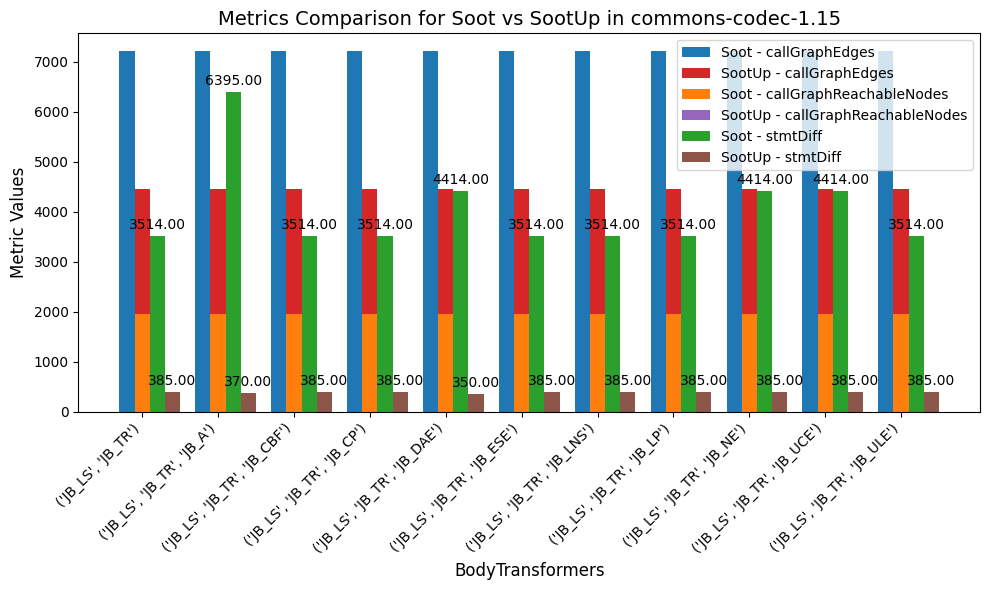

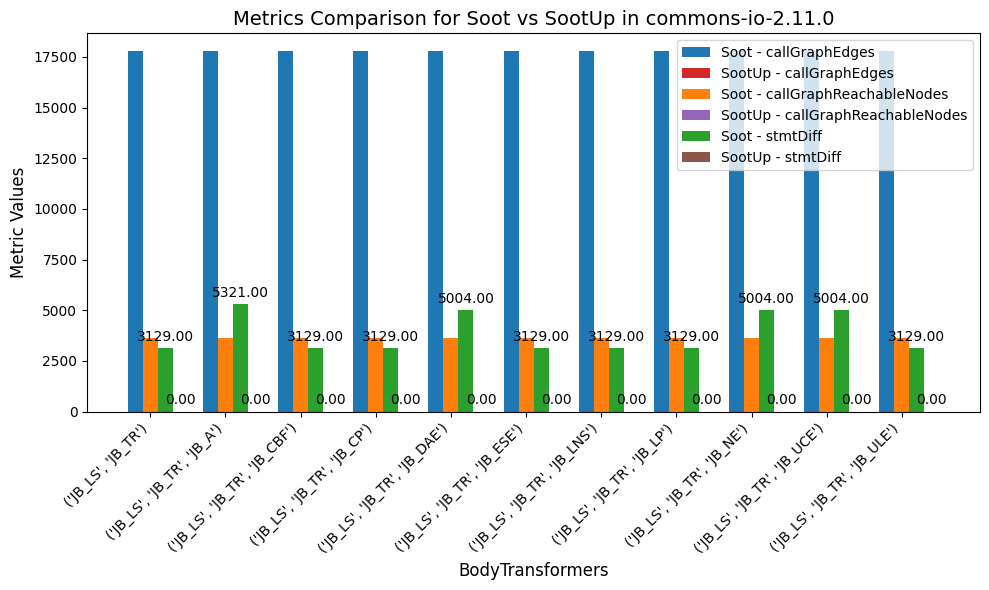

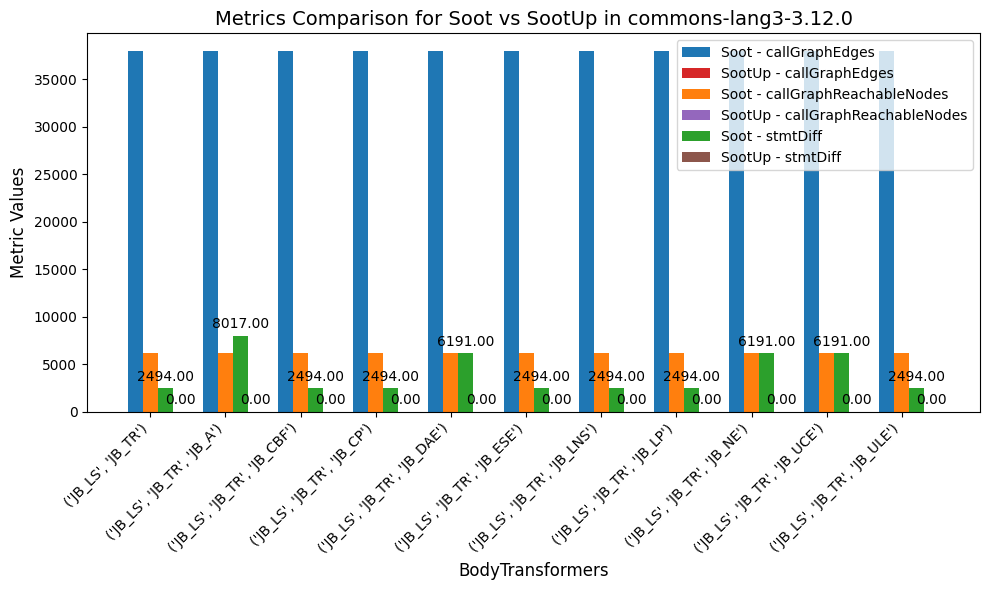

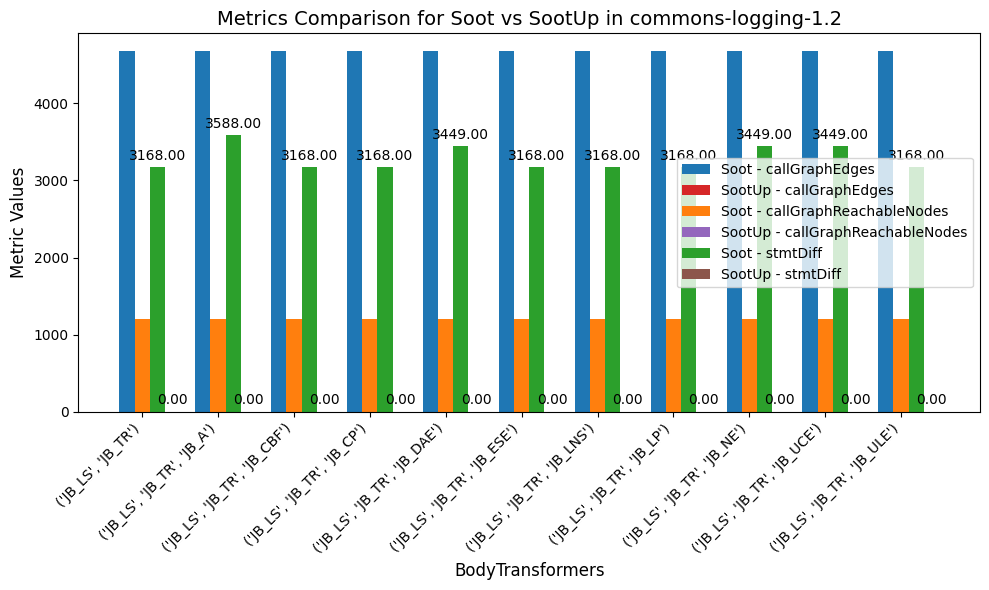

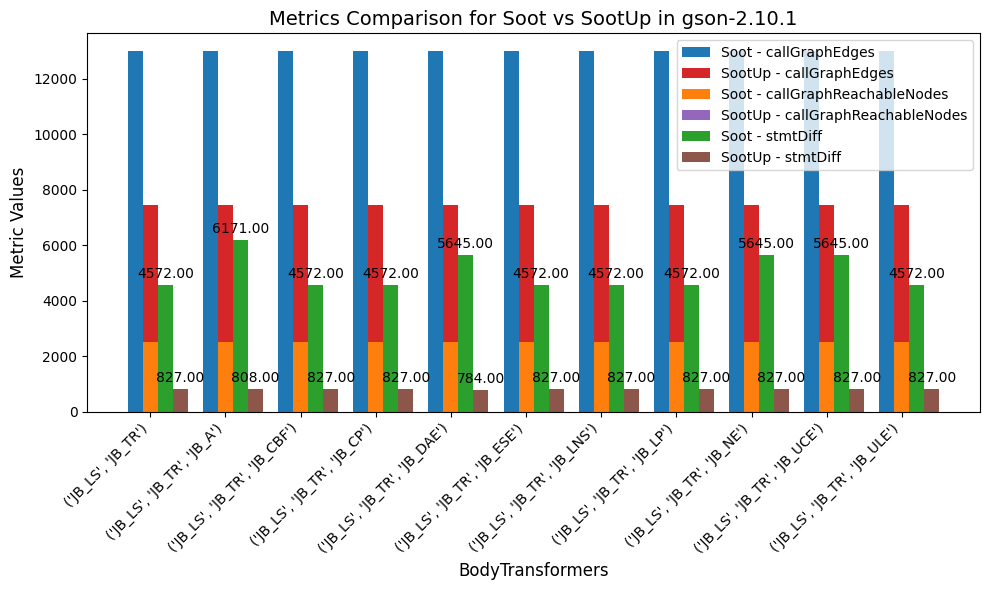

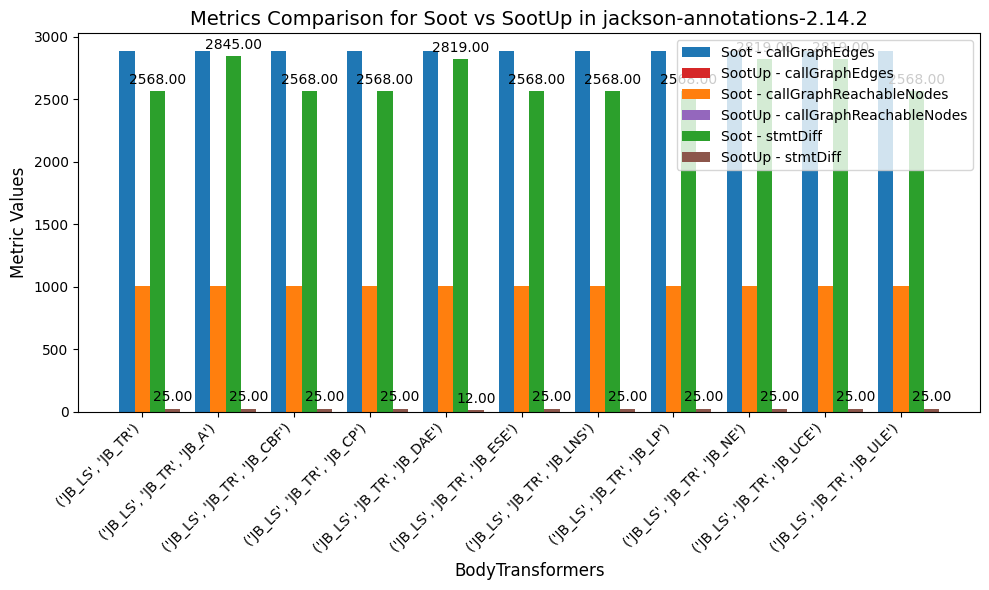

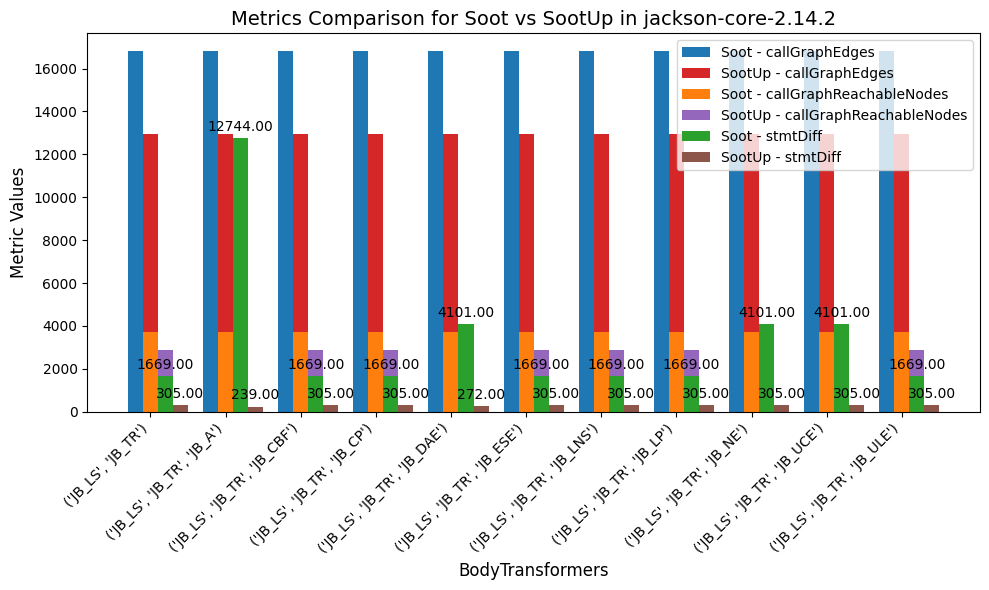

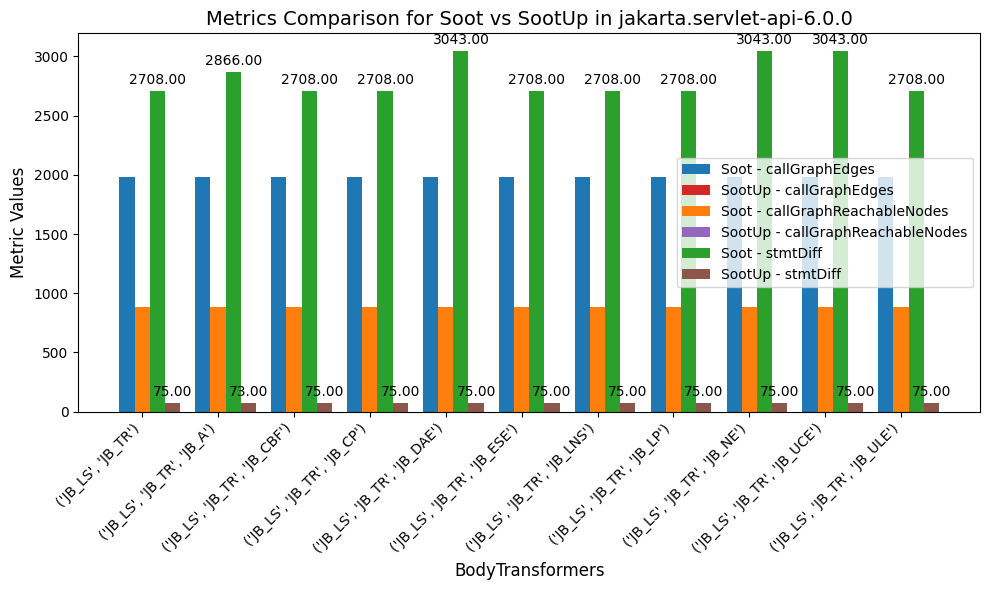

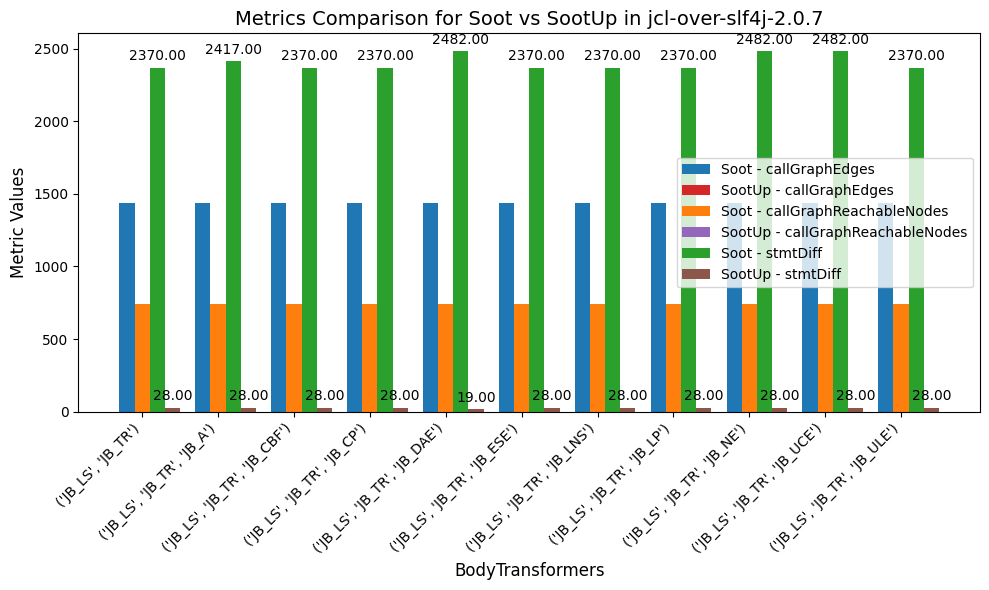

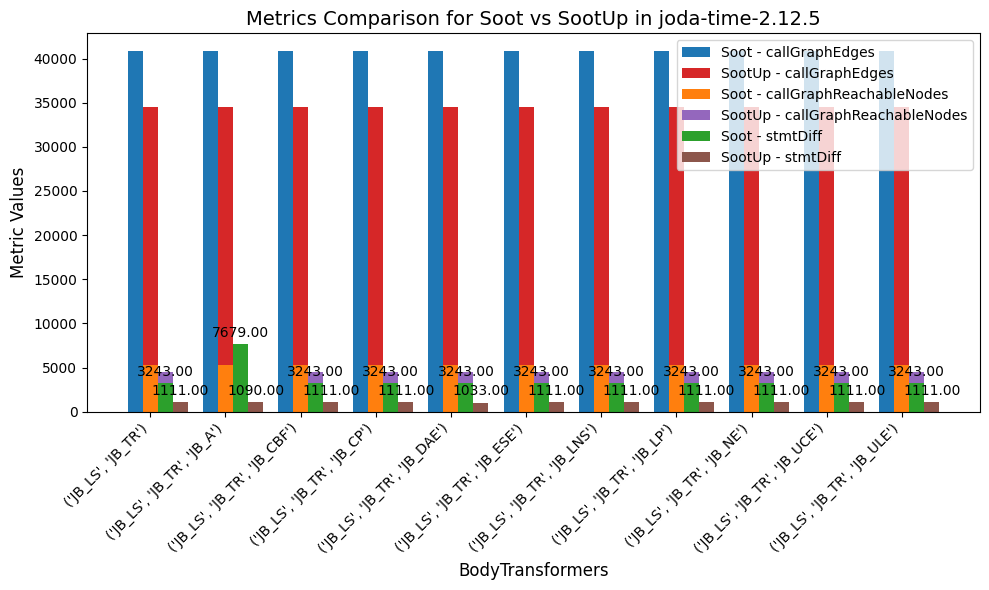

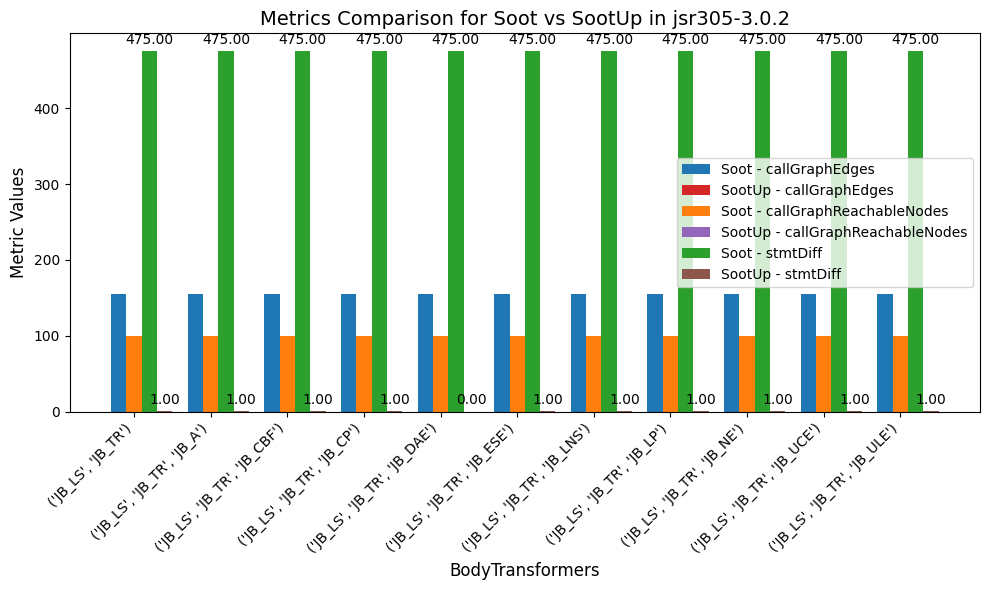

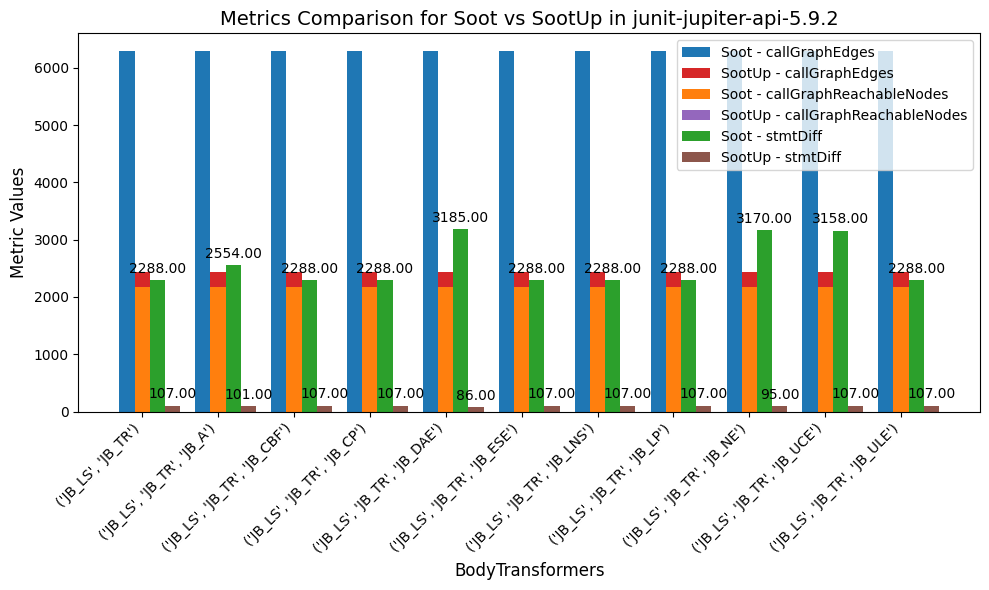

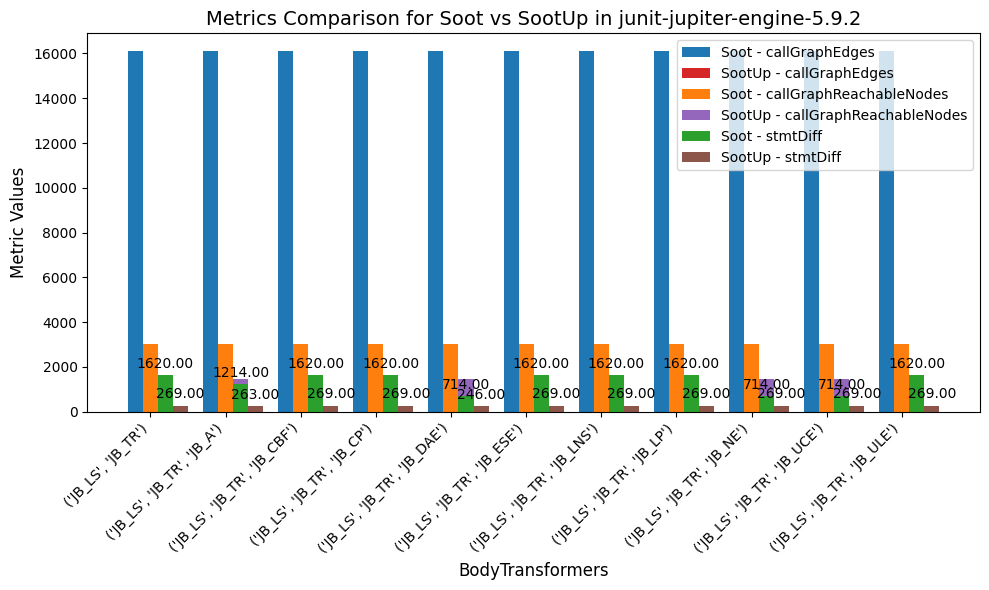

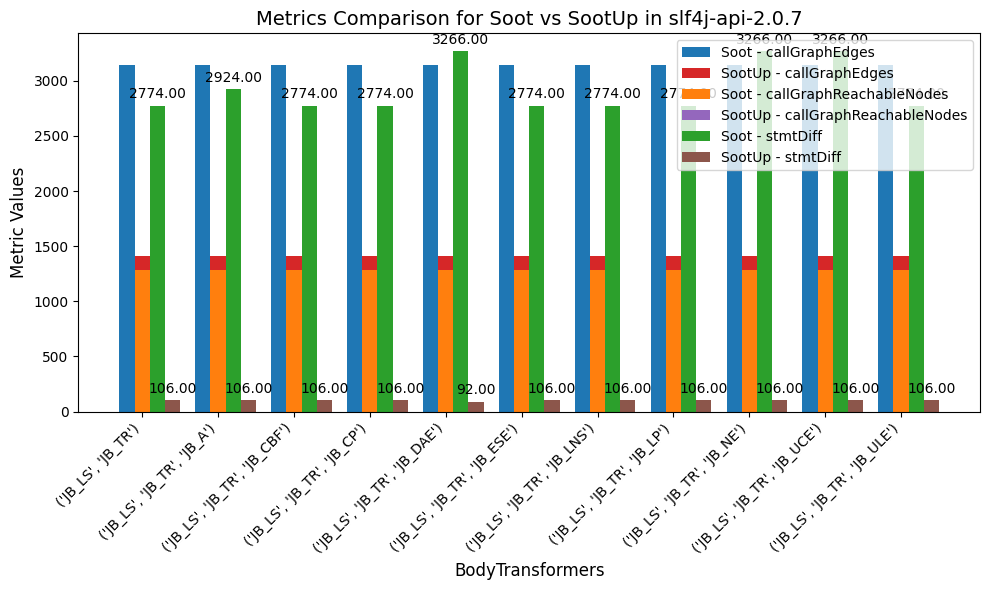

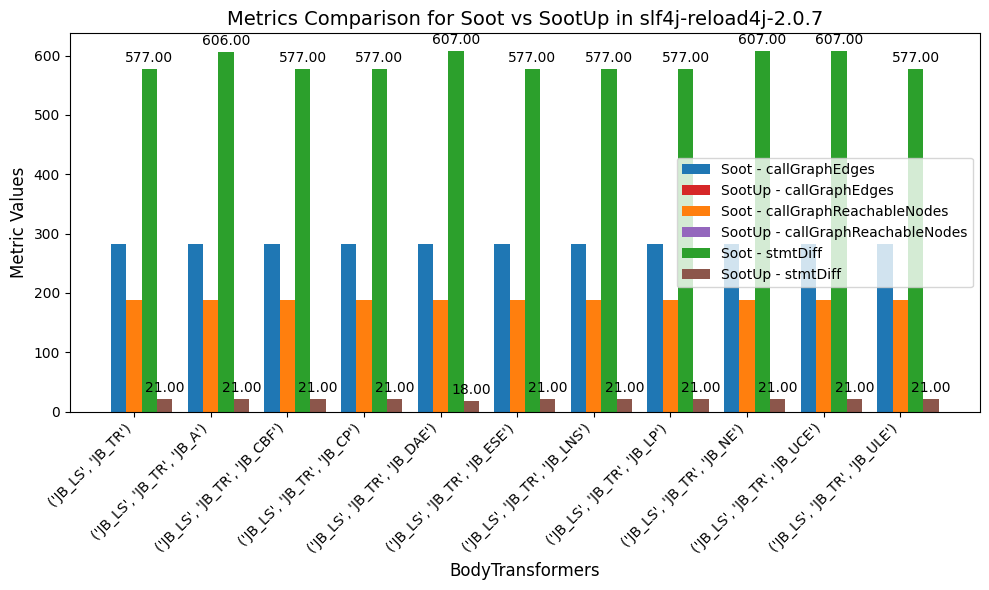

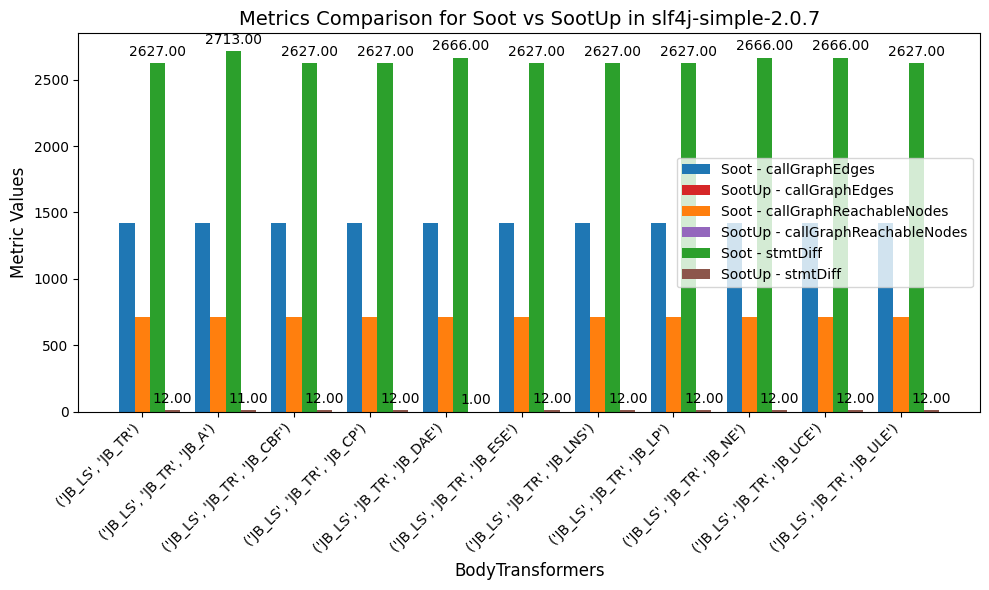

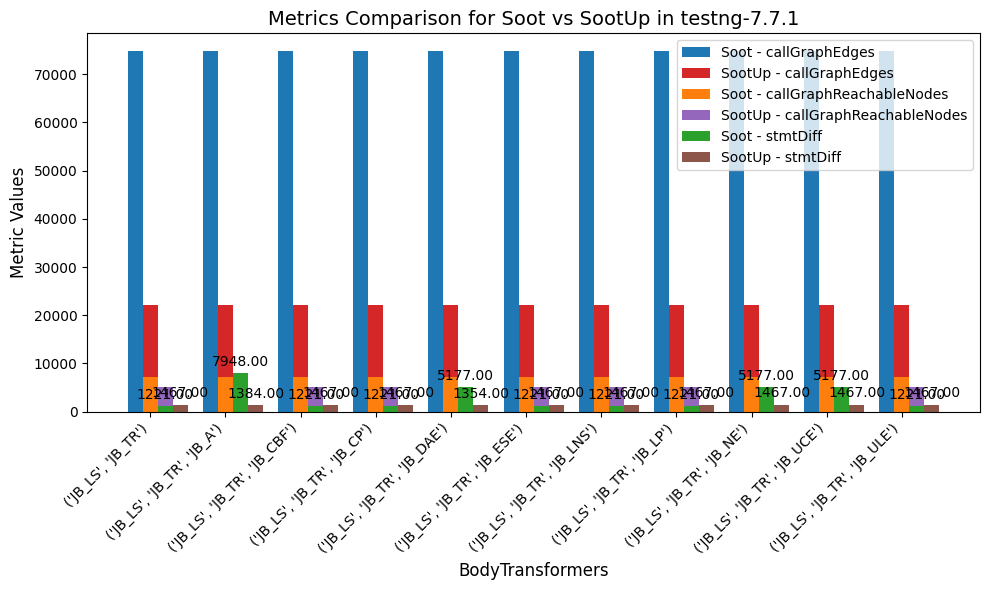

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_cha_compare_test'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Filter the data to only include rows where CallGraphAlgo is 'CHA'
df_soot_cha = df_soot_analysis[df_soot_analysis['CallGraphAlgo'] == 'CHA']
df_sootup_cha = df_sootup_analysis[df_sootup_analysis['CallGraphAlgo'] == 'CHA']

# Sample data (assuming df_soot_cha and df_sootup_cha are predefined)
data_soot = {
    'jar': df_soot_cha['jar'].values.tolist(),
    'callGraphEdges': df_soot_cha['callGraphEdges'].values.tolist(),
    'callGraphReachableNodes': df_soot_cha['callGraphReachableNodes'].values.tolist(),
    'stmtDiff': abs(df_soot_cha['stmtDiff']).values.tolist(),
    'BodyTransformers': df_soot_cha['BodyTransformers'].values.tolist(),
    'type': ['soot'] * len(df_soot_cha)  # Label for soot data
}

data_sootup = {
    'jar': df_sootup_cha['jar'].values.tolist(),
    'callGraphEdges': df_sootup_cha['callGraphEdges'].values.tolist(),
    'callGraphReachableNodes': df_sootup_cha['callGraphReachableNodes'].values.tolist(),
    'stmtDiff': abs(df_sootup_cha['stmtDiff']).values.tolist(),
    'BodyTransformers': df_sootup_cha['BodyInterceptors'].values.tolist(),
    'type': ['sootup'] * len(df_sootup_cha)  # Label for sootup data
}

# Create DataFrames
df_soot = pd.DataFrame(data_soot)
df_sootup = pd.DataFrame(data_sootup)

# Combine soot and sootup data
df_combined = pd.concat([df_soot, df_sootup])

# Convert the 'BodyTransformers' column to tuples so they can be used for grouping
df_combined['BodyTransformers'] = df_combined['BodyTransformers'].apply(tuple)

# Define the list of BodyTransformers to exclude
exclude_transformers = [
    ('JB_LS', 'JB_TR', 'JB_DTR'),
    ('JB_LS', 'JB_TR', 'JB_SILS')
]

# Filter out the excluded transformers
df_combined = df_combined[~df_combined['BodyTransformers'].isin(exclude_transformers)]

# Group by jar, BodyTransformers, and type, and calculate mean for the required columns
grouped_df = df_combined.groupby(['jar', 'BodyTransformers', 'type'], as_index=False).agg({
    'callGraphEdges': 'mean',
    'callGraphReachableNodes': 'mean',
    'stmtDiff': 'mean'
})

# Plot bar chart for each unique jar
for jar in grouped_df['jar'].unique():
    # Filter the data for the current jar
    df_jar = grouped_df[grouped_df['jar'] == jar]
    
    # Pivot the data to have 'soot' and 'sootup' as columns for side-by-side comparison
    df_pivot = df_jar.pivot(index='BodyTransformers', columns='type', values=['callGraphEdges', 'callGraphReachableNodes', 'stmtDiff']).fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0
    
    # Create the bar chart
    metrics = ['callGraphEdges', 'callGraphReachableNodes', 'stmtDiff']
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.2  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars for soot and sootup for each metric
    for i, metric in enumerate(metrics):
        # Check if the 'soot' and 'sootup' columns for this metric exist in the pivoted DataFrame
        soot_values = df_pivot[(metric, 'soot')] if (metric, 'soot') in df_pivot else [0] * len(df_pivot)
        sootup_values = df_pivot[(metric, 'sootup')] if (metric, 'sootup') in df_pivot else [0] * len(df_pivot)
        # Plot the bars
        rects1 = ax.bar(x - width + i * width, soot_values, width, label=f'Soot - {metric}', color=f'C{i}')
        rects2 = ax.bar(x + i * width, sootup_values, width, label=f'SootUp - {metric}', color=f'C{i+3}')
    
    # Add labels and title
    ax.set_xlabel('BodyTransformers', fontsize=12)
    ax.set_ylabel('Metric Values', fontsize=12)
    ax.set_title(f'Metrics Comparison for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Label the bars for both soot and sootup
    for rects in [rects1, rects2]:
        autolabel(rects)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    plt.show()
    # plot_filename = os.path.join(output_directory, f'{jar}_soot_sootup_comparison.png')
    # plt.xticks(rotation = 90)
    # plt.savefig(plot_filename)
    # # Clear the figure to avoid overlapping of plots in the next iteration
    # plt.close(fig)


### Each jar (CHA): Comparing Soot and Sootup individual Comparision cgConstructionTime

In [6]:
# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individualjar_cha_individualBI_cgConstructionTime'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Filter the data to only include rows where CallGraphAlgo is 'CHA'
df_soot_cha = df_soot_analysis[df_soot_analysis['CallGraphAlgo'] == 'CHA']
df_sootup_cha = df_sootup_analysis[df_sootup_analysis['CallGraphAlgo'] == 'CHA']

# Sample data (assuming df_soot_cha and df_sootup_cha are predefined)
data_soot = {
    'jar': df_soot_cha['jar'].values.tolist(),
    'cgConstructionTime': df_soot_cha['cgConstructionTime'].values.tolist(),
    'BodyTransformers': df_soot_cha['BodyTransformers'].values.tolist(),
    'type': ['soot'] * len(df_soot_cha)  # Label for soot data
}

data_sootup = {
    'jar': df_sootup_cha['jar'].values.tolist(),
    'cgConstructionTime': df_sootup_cha['cgConstructionTime'].values.tolist(),
    'BodyTransformers': df_sootup_cha['BodyInterceptors'].values.tolist(),
    'type': ['sootup'] * len(df_sootup_cha)  # Label for sootup data
}

# Create DataFrames
df_soot = pd.DataFrame(data_soot)
df_sootup = pd.DataFrame(data_sootup)

# Combine soot and sootup data
df_combined = pd.concat([df_soot, df_sootup])

# Convert the 'BodyTransformers' column to tuples so they can be used for grouping
df_combined['BodyTransformers'] = df_combined['BodyTransformers'].apply(tuple)

# Define the list of BodyTransformer to exclude
exclude_transformers = [
    ('JB_LS', 'JB_TR', 'JB_DTR'),
    ('JB_LS', 'JB_TR', 'JB_SILS')
]

# Filter out the excluded transformers (optional)
df_combined = df_combined[~df_combined['BodyTransformers'].isin(exclude_transformers)]

# Group by jar, BodyTransformers, and type
grouped_df = df_combined.groupby(['jar', 'BodyTransformers', 'type'], as_index=False).agg({'cgConstructionTime': 'mean'})

# Plot bar chart for each unique jar
for jar in grouped_df['jar'].unique():
    # Filter the data for the current jar
    df_jar = grouped_df[grouped_df['jar'] == jar]
    
    # Pivot the data to have 'soot' and 'sootup' as columns for side-by-side comparison
    df_pivot = df_jar.pivot(index='BodyTransformers', columns='type', values='cgConstructionTime').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0
    
    # Create the bar chart
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyTransformers', fontsize=12)
    ax.set_ylabel('Mean cgConstructionTime', fontsize=12)
    ax.set_title(f'Mean cgConstructionTime for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_soot_sootup_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

### Each jar (CHA): Comparing Soot and Sootup individual Comparision callGraphEdges

In [7]:
# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individualjar_cha_individualBI_callGraphEdges'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist


# Filter the data to only include rows where CallGraphAlgo is 'CHA'
df_soot_cha = df_soot_analysis[df_soot_analysis['CallGraphAlgo'] == 'CHA']
df_sootup_cha = df_sootup_analysis[df_sootup_analysis['CallGraphAlgo'] == 'CHA']

# Sample data (assuming df_soot_cha and df_sootup_cha are predefined)
data_soot = {
    'jar': df_soot_cha['jar'].values.tolist(),
    'callGraphEdges': df_soot_cha['callGraphEdges'].values.tolist(),
    'BodyTransformers': df_soot_cha['BodyTransformers'].values.tolist(),
    'type': ['soot'] * len(df_soot_cha)  # Label for soot data
}

data_sootup = {
    'jar': df_sootup_cha['jar'].values.tolist(),
    'callGraphEdges': df_sootup_cha['callGraphEdges'].values.tolist(),
    'BodyTransformers': df_sootup_cha['BodyInterceptors'].values.tolist(),
    'type': ['sootup'] * len(df_sootup_cha)  # Label for sootup data
}

# Create DataFrames
df_soot = pd.DataFrame(data_soot)
df_sootup = pd.DataFrame(data_sootup)

# Combine soot and sootup data
df_combined = pd.concat([df_soot, df_sootup])

# Convert the 'BodyTransformers' column to tuples so they can be used for grouping
df_combined['BodyTransformers'] = df_combined['BodyTransformers'].apply(tuple)

# Define the list of BodyTransformer to exclude
exclude_transformers = [
    ('JB_LS', 'JB_TR', 'JB_DTR'),
    ('JB_LS', 'JB_TR', 'JB_SILS')
]

# Filter out the excluded transformers (optional)
df_combined = df_combined[~df_combined['BodyTransformers'].isin(exclude_transformers)]

# Group by jar, BodyTransformers, and type
grouped_df = df_combined.groupby(['jar', 'BodyTransformers', 'type'], as_index=False).agg({'callGraphEdges': 'mean'})

# Plot bar chart for each unique jar
for jar in grouped_df['jar'].unique():
    # Filter the data for the current jar
    df_jar = grouped_df[grouped_df['jar'] == jar]
    
    # Pivot the data to have 'soot' and 'sootup' as columns for side-by-side comparison
    df_pivot = df_jar.pivot(index='BodyTransformers', columns='type', values='callGraphEdges').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0
    
    # Create the bar chart
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyTransformers', fontsize=12)
    ax.set_ylabel('CallGraphEdges', fontsize=12)
    ax.set_title(f'Mean CallGraphEdges for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_soot_sootup_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

### Each jar (CHA): Comparing Soot and Sootup individual Comparision callGraphReachableNodes

In [8]:
# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individualjar_cha_individualBI_callGraphReachableNodes'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Filter the data to only include rows where CallGraphAlgo is 'CHA'
df_soot_cha = df_soot_analysis[df_soot_analysis['CallGraphAlgo'] == 'CHA']
df_sootup_cha = df_sootup_analysis[df_sootup_analysis['CallGraphAlgo'] == 'CHA']

# Sample data (assuming df_soot_cha and df_sootup_cha are predefined)
data_soot = {
    'jar': df_soot_cha['jar'].values.tolist(),
    'callGraphReachableNodes': df_soot_cha['callGraphReachableNodes'].values.tolist(),
    'BodyTransformers': df_soot_cha['BodyTransformers'].values.tolist(),
    'type': ['soot'] * len(df_soot_cha)  # Label for soot data
}

data_sootup = {
    'jar': df_sootup_cha['jar'].values.tolist(),
    'callGraphReachableNodes': df_sootup_cha['callGraphReachableNodes'].values.tolist(),
    'BodyTransformers': df_sootup_cha['BodyInterceptors'].values.tolist(),
    'type': ['sootup'] * len(df_sootup_cha)  # Label for sootup data
}

# Create DataFrames
df_soot = pd.DataFrame(data_soot)
df_sootup = pd.DataFrame(data_sootup)

# Combine soot and sootup data
df_combined = pd.concat([df_soot, df_sootup])

# Convert the 'BodyTransformers' column to tuples so they can be used for grouping
df_combined['BodyTransformers'] = df_combined['BodyTransformers'].apply(tuple)

# Define the list of BodyTransformer to exclude
exclude_transformers = [
    ('JB_LS', 'JB_TR', 'JB_DTR'),
    ('JB_LS', 'JB_TR', 'JB_SILS')
]

# Filter out the excluded transformers (optional)
df_combined = df_combined[~df_combined['BodyTransformers'].isin(exclude_transformers)]

# Group by jar, BodyTransformers, and type
grouped_df = df_combined.groupby(['jar', 'BodyTransformers', 'type'], as_index=False).agg({'callGraphReachableNodes': 'mean'})

# Plot bar chart for each unique jar
for jar in grouped_df['jar'].unique():
    # Filter the data for the current jar
    df_jar = grouped_df[grouped_df['jar'] == jar]
    
    # Pivot the data to have 'soot' and 'sootup' as columns for side-by-side comparison
    df_pivot = df_jar.pivot(index='BodyTransformers', columns='type', values='callGraphReachableNodes').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0
    
    # Create the bar chart
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyTransformers', fontsize=12)
    ax.set_ylabel('CallGraphReachableNodes', fontsize=12)
    ax.set_title(f'Mean cgConstructionTime for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_soot_sootup_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

### Each jar (CHA): Comparing Soot and Sootup individual Comparision stmtDiff 

In [9]:
# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individualjar_cha_individualBI_stmtDiff'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Filter the data to only include rows where CallGraphAlgo is 'CHA'
df_soot_cha = df_soot_analysis[df_soot_analysis['CallGraphAlgo'] == 'CHA']
df_sootup_cha = df_sootup_analysis[df_sootup_analysis['CallGraphAlgo'] == 'CHA']

# Sample data (assuming df_soot_cha and df_sootup_cha are predefined)
data_soot = {
    'jar': df_soot_cha['jar'].values.tolist(),
    'stmtDiff': df_soot_cha['stmtDiff'].values.tolist(),
    'BodyTransformers': df_soot_cha['BodyTransformers'].values.tolist(),
    'type': ['soot'] * len(df_soot_cha)  # Label for soot data
}

data_sootup = {
    'jar': df_sootup_cha['jar'].values.tolist(),
    'stmtDiff': df_sootup_cha['stmtDiff'].values.tolist(),
    'BodyTransformers': df_sootup_cha['BodyInterceptors'].values.tolist(),
    'type': ['sootup'] * len(df_sootup_cha)  # Label for sootup data
}

# Create DataFrames
df_soot = pd.DataFrame(data_soot)
df_sootup = pd.DataFrame(data_sootup)

# Combine soot and sootup data
df_combined = pd.concat([df_soot, df_sootup])

# Convert the 'BodyTransformers' column to tuples so they can be used for grouping
df_combined['BodyTransformers'] = df_combined['BodyTransformers'].apply(tuple)

# Define the list of BodyTransformer to exclude
exclude_transformers = [
    ('JB_LS', 'JB_TR', 'JB_DTR'),
    ('JB_LS', 'JB_TR', 'JB_SILS')
]

# Filter out the excluded transformers (optional)
df_combined = df_combined[~df_combined['BodyTransformers'].isin(exclude_transformers)]

# Group by jar, BodyTransformers, and type
grouped_df = df_combined.groupby(['jar', 'BodyTransformers', 'type'], as_index=False).agg({'stmtDiff': 'mean'})

# Plot bar chart for each unique jar
for jar in grouped_df['jar'].unique():
    # Filter the data for the current jar
    df_jar = grouped_df[grouped_df['jar'] == jar]
    
    # Pivot the data to have 'soot' and 'sootup' as columns for side-by-side comparison
    df_pivot = df_jar.pivot(index='BodyTransformers', columns='type', values='stmtDiff').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0
    
    # Create the bar chart
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyTransformers', fontsize=12)
    ax.set_ylabel('StmtDiff', fontsize=12)
    ax.set_title(f'Mean cgConstructionTime for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_soot_sootup_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

### Corelation of cgConstructionTime with each of the following: cgEdges, cgReachableNodes, StmtDiff

### Soot Correlation Matrix & LinearRegression between each body transformer & cgConstructionTime (CHA)

Correlation matrix between transformers and cgConstructionTime:
cgConstructionTime    1.000000
jb.tr                 0.955838
jb.lp                 0.908841
jb.a                  0.848400
jb.ls                 0.834792
jb.ule                0.627244
jb.cp                 0.447525
jb.ese                0.427919
jb.dae                0.320884
jb.uce                0.264766
jb.cbf                0.124175
Name: cgConstructionTime, dtype: float64


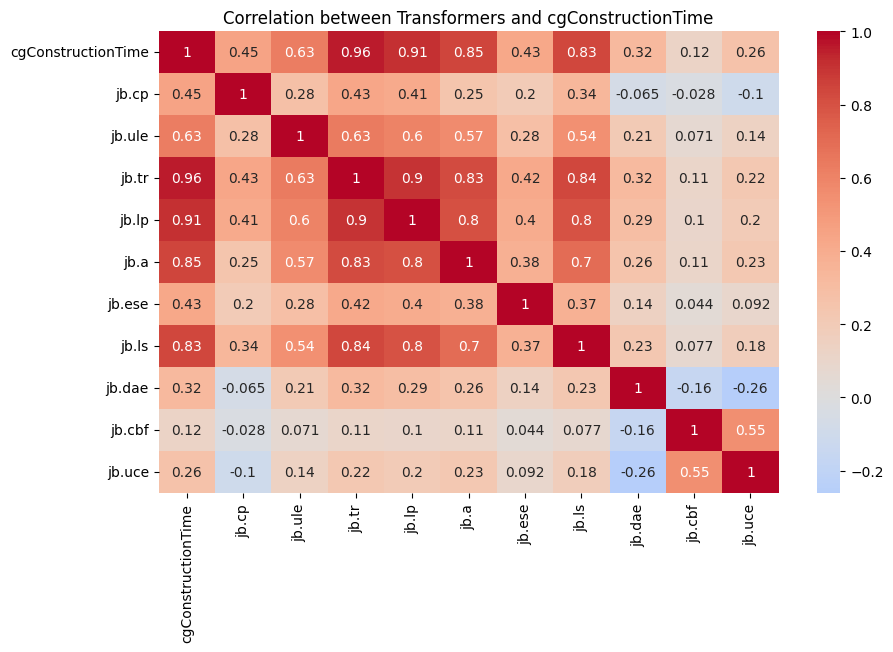


Linear regression coefficients:
jb.ese    3.193128
jb.tr     1.840278
jb.uce    1.704698
jb.cp     1.499400
jb.a      1.396899
jb.lp     1.309111
jb.dae    1.269387
jb.ls     1.116094
jb.ule    0.908200
jb.cbf   -2.278709
dtype: float64


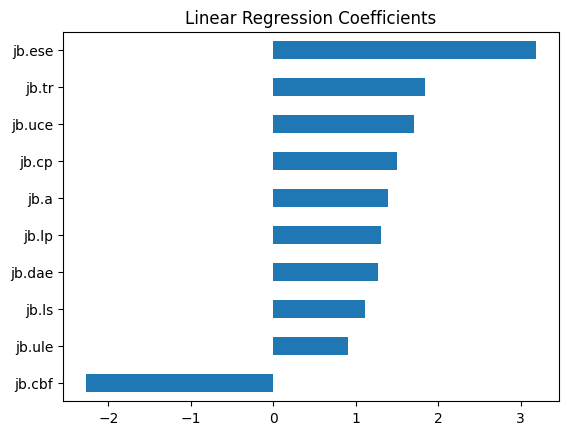

In [56]:
df = pd.DataFrame(df_soot_analysis)

# Filter for CallGraphAlgo = 'CHA'
df_cha = df[df['CallGraphAlgo'] == 'CHA']

# Create a list to store the extracted metrics
metrics_list = []

# Loop through the DataFrame and extract transformer metrics
for idx, row in df_cha.iterrows():
    # Initialize a dictionary to hold the metrics for this row
    row_metrics = {'cgConstructionTime': row['cgConstructionTime']}
    
    # Iterate through each transformer and extract the first value (assuming it's the impact)
    for transformer, values in row['BodyTransformersMetrics'].items():
        # Add the first value (assumed to be the metric we're interested in) to the row
        row_metrics[transformer] = values[0]
    
    # Append the dictionary to the list
    metrics_list.append(row_metrics)

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Fill NaN with 0 (if any transformers are missing in some rows)
metrics_df.fillna(0, inplace=True)

# Perform a correlation analysis
correlation_matrix = metrics_df.corr()

# Display the correlation matrix
print("Correlation matrix between transformers and cgConstructionTime:")
print(correlation_matrix['cgConstructionTime'].sort_values(ascending=False))

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Transformers and cgConstructionTime')
plt.show()

# Alternatively, you can perform a linear regression to see the impact of transformers on cgConstructionTime
X = metrics_df.drop(columns=['cgConstructionTime'])
y = metrics_df['cgConstructionTime']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Print coefficients for each transformer
coefficients = pd.Series(model.coef_, index=X.columns)
print("\nLinear regression coefficients:")
print(coefficients.sort_values(ascending=False))

# Plot the coefficients
coefficients.sort_values(ascending=True).plot(kind='barh', title='Linear Regression Coefficients')
plt.show()

### SootUp Correlation Matrix & LinearRegression between each body interceptor & cgConstructionTime (CHA)

Correlation matrix between transformers and cgConstructionTime:
cgConstructionTime    1.000000
jb.tr                 0.755727
jb.a                  0.732687
jb.ule                0.665712
jb.ls                 0.660031
jb.lp                 0.594269
jb.ese                0.311125
jb.cp                 0.293637
jb.cbf                0.136783
jb.dae                0.043362
Name: cgConstructionTime, dtype: float64


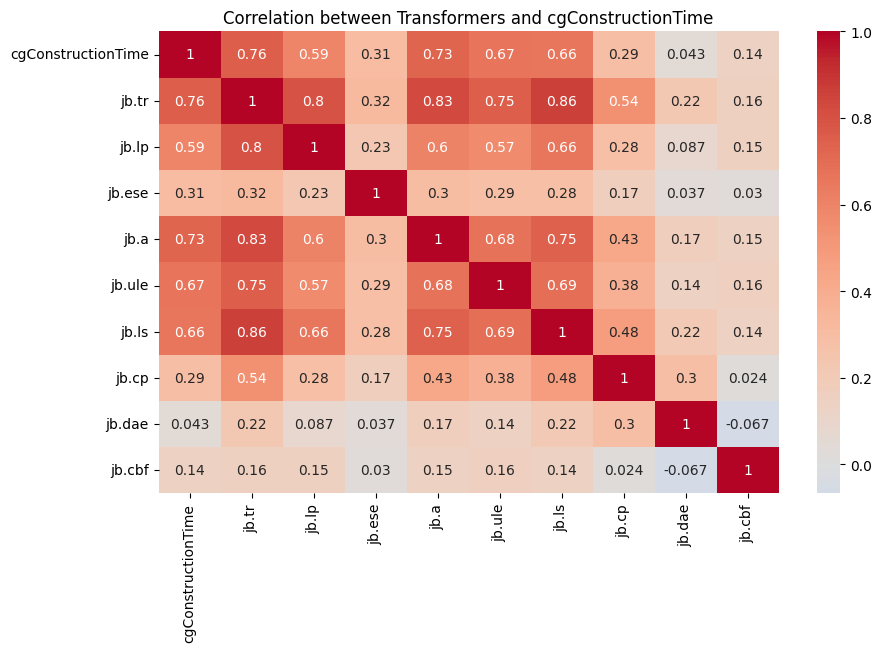


Linear regression coefficients:
jb.ese    2.598816
jb.ule    1.569750
jb.a      1.146232
jb.tr     0.292262
jb.dae   -0.016016
jb.lp    -0.020163
jb.ls    -0.062003
jb.cbf   -0.216807
jb.cp    -0.255507
dtype: float64


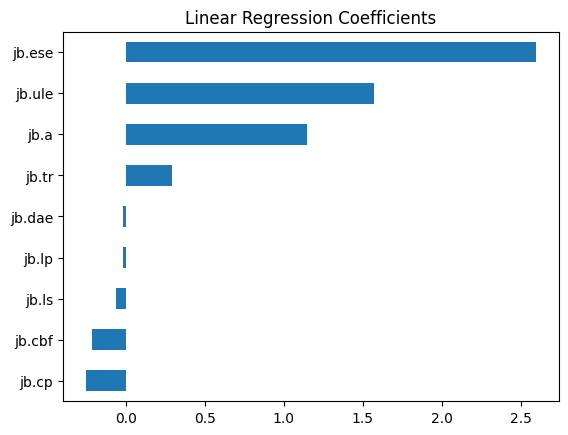

In [59]:
df = pd.DataFrame(df_sootup_analysis)

# Filter for CallGraphAlgo = 'CHA'
df_cha = df[df['CallGraphAlgo'] == 'CHA']

# Create a list to store the extracted metrics
metrics_list = []

# Loop through the DataFrame and extract transformer metrics
for idx, row in df_cha.iterrows():
    # Initialize a dictionary to hold the metrics for this row
    row_metrics = {'cgConstructionTime': row['cgConstructionTime']}
    
    # Iterate through each transformer and extract the first value (assuming it's the impact)
    for transformer, values in row['BodyInterceptorsMetrics'].items():
        # Add the first value (assumed to be the metric we're interested in) to the row
        row_metrics[transformer] = values[0]
    
    # Append the dictionary to the list
    metrics_list.append(row_metrics)

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Fill NaN with 0 (if any transformers are missing in some rows)
metrics_df.fillna(0, inplace=True)

# Perform a correlation analysis
correlation_matrix = metrics_df.corr()

# Display the correlation matrix
print("Correlation matrix between transformers and cgConstructionTime:")
print(correlation_matrix['cgConstructionTime'].sort_values(ascending=False))

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Transformers and cgConstructionTime')
plt.show()

# Alternatively, you can perform a linear regression to see the impact of transformers on cgConstructionTime
X = metrics_df.drop(columns=['cgConstructionTime'])
y = metrics_df['cgConstructionTime']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Print coefficients for each transformer
coefficients = pd.Series(model.coef_, index=X.columns)
print("\nLinear regression coefficients:")
print(coefficients.sort_values(ascending=False))

# Plot the coefficients
coefficients.sort_values(ascending=True).plot(kind='barh', title='Linear Regression Coefficients')
plt.show()

### Soot Correlation Matrix & LinearRegression between each body transformer & cgConstructionTime (RTA)

Correlation matrix between transformers and cgConstructionTime:
cgConstructionTime    1.000000
jb.tr                 0.817132
jb.ls                 0.643382
jb.lp                 0.214440
jb.ese                0.090765
jb.uce                0.052044
jb.ne                 0.044557
jb.dae                0.014911
jb.ule               -0.008776
jb.cp                -0.022856
jb.a                 -0.035492
jb.cbf               -0.043198
jb.lns               -0.054947
Name: cgConstructionTime, dtype: float64


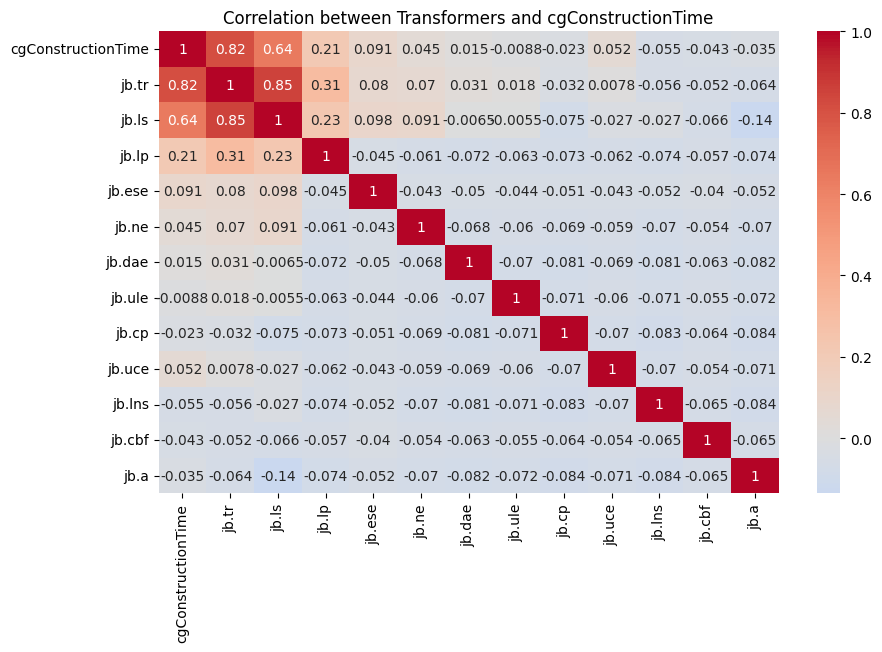


Linear regression coefficients:
jb.ese    21.740334
jb.tr      6.637983
jb.uce     1.974292
jb.a      -0.353347
jb.cp     -1.064832
jb.lns    -1.130935
jb.lp     -1.269717
jb.dae    -1.431312
jb.ls     -2.514388
jb.ule    -9.824390
jb.cbf   -10.574711
jb.ne    -12.317028
dtype: float64


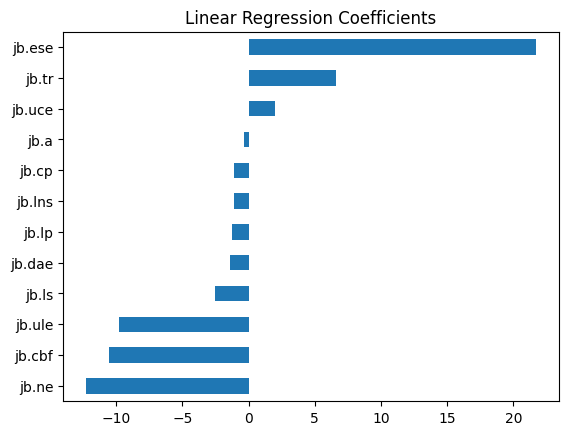

In [5]:
df = pd.DataFrame(df_soot_analysis)

# Filter for CallGraphAlgo = 'RTA'
df_cha = df[df['CallGraphAlgo'] == 'RTA']

# Create a list to store the extracted metrics
metrics_list = []

# Loop through the DataFrame and extract transformer metrics
for idx, row in df_cha.iterrows():
    # Initialize a dictionary to hold the metrics for this row
    row_metrics = {'cgConstructionTime': row['cgConstructionTime']}
    
    # Iterate through each transformer and extract the first value (assuming it's the impact)
    for transformer, values in row['BodyTransformersMetrics'].items():
        # Add the first value (assumed to be the metric we're interested in) to the row
        row_metrics[transformer] = values[0]
    
    # Append the dictionary to the list
    metrics_list.append(row_metrics)

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Fill NaN with 0 (if any transformers are missing in some rows)
metrics_df.fillna(0, inplace=True)

# Perform a correlation analysis
correlation_matrix = metrics_df.corr()

# Display the correlation matrix
print("Correlation matrix between transformers and cgConstructionTime:")
print(correlation_matrix['cgConstructionTime'].sort_values(ascending=False))

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Transformers and cgConstructionTime')
plt.show()

# Alternatively, you can perform a linear regression to see the impact of transformers on cgConstructionTime
X = metrics_df.drop(columns=['cgConstructionTime'])
y = metrics_df['cgConstructionTime']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Print coefficients for each transformer
coefficients = pd.Series(model.coef_, index=X.columns)
print("\nLinear regression coefficients:")
print(coefficients.sort_values(ascending=False))

# Plot the coefficients
coefficients.sort_values(ascending=True).plot(kind='barh', title='Linear Regression Coefficients')
plt.show()

### SootUp Correlation Matrix & LinearRegression between each body interceptor & cgConstructionTime (RTA)

Correlation matrix between transformers and cgConstructionTime:
cgConstructionTime    1.000000
jb.tr                 0.760122
jb.a                  0.748872
jb.ls                 0.672677
jb.ule                0.661673
jb.lp                 0.580695
jb.ese                0.360742
jb.cp                 0.293652
jb.cbf                0.134365
jb.dae                0.047423
Name: cgConstructionTime, dtype: float64


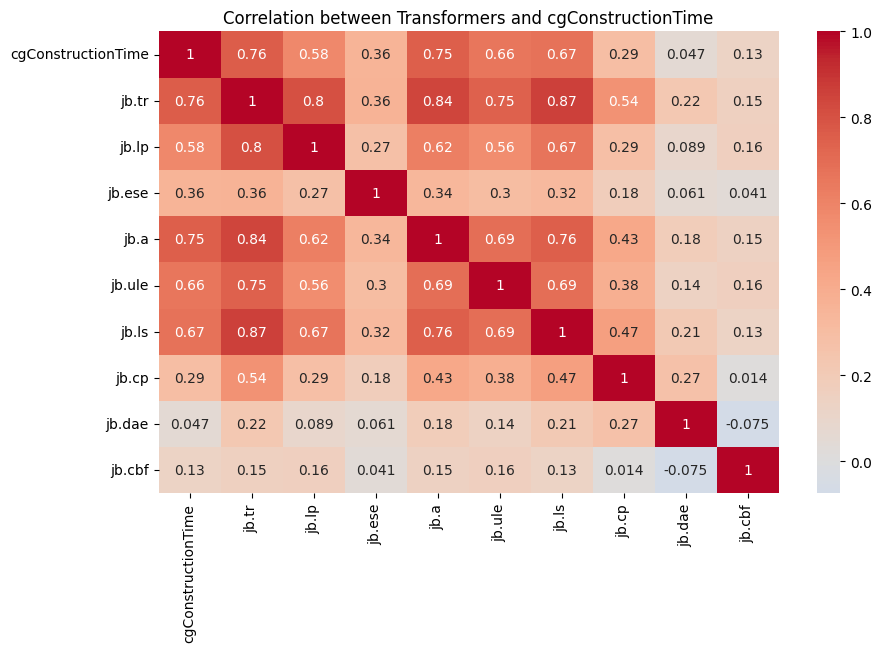


Linear regression coefficients:
jb.ese    4.043235
jb.ule    1.439502
jb.a      1.238860
jb.tr     0.334294
jb.ls    -0.003222
jb.dae   -0.018716
jb.lp    -0.053190
jb.cbf   -0.258265
jb.cp    -0.303455
dtype: float64


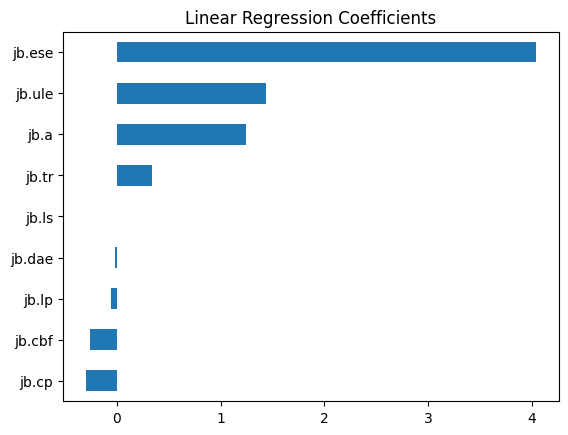

In [61]:
df = pd.DataFrame(df_sootup_analysis)

# Filter for CallGraphAlgo = 'RTA'
df_cha = df[df['CallGraphAlgo'] == 'RTA']

# Create a list to store the extracted metrics
metrics_list = []

# Loop through the DataFrame and extract transformer metrics
for idx, row in df_cha.iterrows():
    # Initialize a dictionary to hold the metrics for this row
    row_metrics = {'cgConstructionTime': row['cgConstructionTime']}
    
    # Iterate through each transformer and extract the first value (assuming it's the impact)
    for transformer, values in row['BodyInterceptorsMetrics'].items():
        # Add the first value (assumed to be the metric we're interested in) to the row
        row_metrics[transformer] = values[0]
    
    # Append the dictionary to the list
    metrics_list.append(row_metrics)

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Fill NaN with 0 (if any transformers are missing in some rows)
metrics_df.fillna(0, inplace=True)

# Perform a correlation analysis
correlation_matrix = metrics_df.corr()

# Display the correlation matrix
print("Correlation matrix between transformers and cgConstructionTime:")
print(correlation_matrix['cgConstructionTime'].sort_values(ascending=False))

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Transformers and cgConstructionTime')
plt.show()

# Alternatively, you can perform a linear regression to see the impact of transformers on cgConstructionTime
X = metrics_df.drop(columns=['cgConstructionTime'])
y = metrics_df['cgConstructionTime']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Print coefficients for each transformer
coefficients = pd.Series(model.coef_, index=X.columns)
print("\nLinear regression coefficients:")
print(coefficients.sort_values(ascending=False))

# Plot the coefficients
coefficients.sort_values(ascending=True).plot(kind='barh', title='Linear Regression Coefficients')
plt.show()

## Descriptive Stats: Body Transformer VS cgConstructionTime

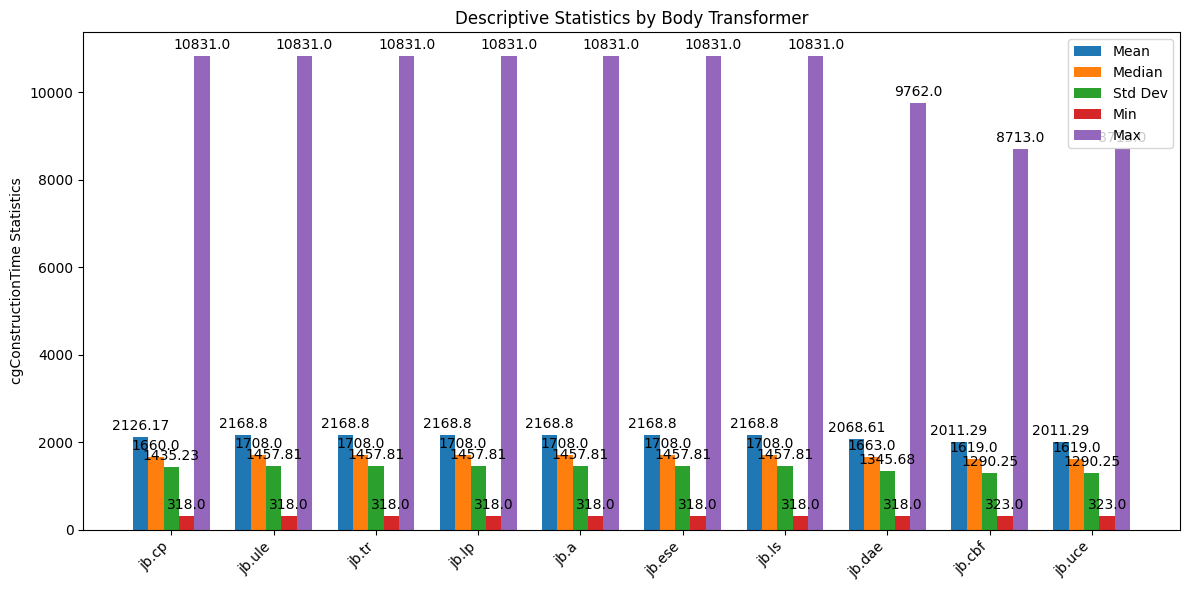

In [8]:
# Sample data
# data = {
#     'totalRuntime': df_soot_analysis['cgConstructionTime'].values.tolist(),
#     'BodyTransformers':  df_soot_analysis['BodyTransformers'].values.tolist()
# }

# Sample data
data = {
    'cgConstructionTime': df_soot_analysis['cgConstructionTime'],
    'BodyTransformersMetrics': df_soot_analysis['BodyTransformersMetrics']
}

# Create DataFrame
df = pd.DataFrame(data)

# Extract the transformer metrics into a more usable format
transformer_stats = {}

# Loop through the DataFrame rows
for idx, row in df.iterrows():
    cg_time = row['cgConstructionTime']
    body_metrics = row['BodyTransformersMetrics']
    
    # Loop through each transformer in BodyTransformersMetrics
    for transformer, values in body_metrics.items():
        # If the transformer is not in the dictionary, initialize it
        if transformer not in transformer_stats:
            transformer_stats[transformer] = []
        # Append the cgConstructionTime for each occurrence of the transformer
        transformer_stats[transformer].append(cg_time)

# Now we calculate descriptive statistics for each transformer
descriptive_stats = {}

for transformer, times in transformer_stats.items():
    descriptive_stats[transformer] = {
        'mean': round(pd.Series(times).mean(), 2),
        'median': round(pd.Series(times).median(), 2),
        'std_dev': round(pd.Series(times).std(), 2),
        'min': round(pd.Series(times).min(), 2),
        'max': round(pd.Series(times).max(), 2)
    }

# # Print the descriptive statistics for each transformer
# for transformer, stats in descriptive_stats.items():
#     print(f"Transformer: {transformer}")
#     print(f"Mean: {stats['mean']}")
#     print(f"Median: {stats['median']}")
#     print(f"Standard Deviation: {stats['std_dev']}")
#     print(f"Min: {stats['min']}")
#     print(f"Max: {stats['max']}")
#     print("-" * 30)


# Prepare data for plotting
transformers = list(descriptive_stats.keys())
metrics = ['mean', 'median', 'std_dev', 'min', 'max']

# Extract the values for plotting
values = np.array([[descriptive_stats[transformer][metric] for metric in metrics] for transformer in transformers])

# Create plot
x = np.arange(len(transformers))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
rects1 = ax.bar(x - 2*width, values[:, 0], width, label='Mean')
rects2 = ax.bar(x - width, values[:, 1], width, label='Median')
rects3 = ax.bar(x, values[:, 2], width, label='Std Dev')
rects4 = ax.bar(x + width, values[:, 3], width, label='Min')
rects5 = ax.bar(x + 2*width, values[:, 4], width, label='Max')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('cgConstructionTime Statistics')
ax.set_title('Descriptive Statistics by Body Transformer')
ax.set_xticks(x)
ax.set_xticklabels(transformers, rotation=45, ha='right')
ax.legend()

# Function to label the bars with their heights
def autolabel(rects):
    """Attach a text label above each bar in rects, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Label each bar
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

fig.tight_layout()
plt.show()


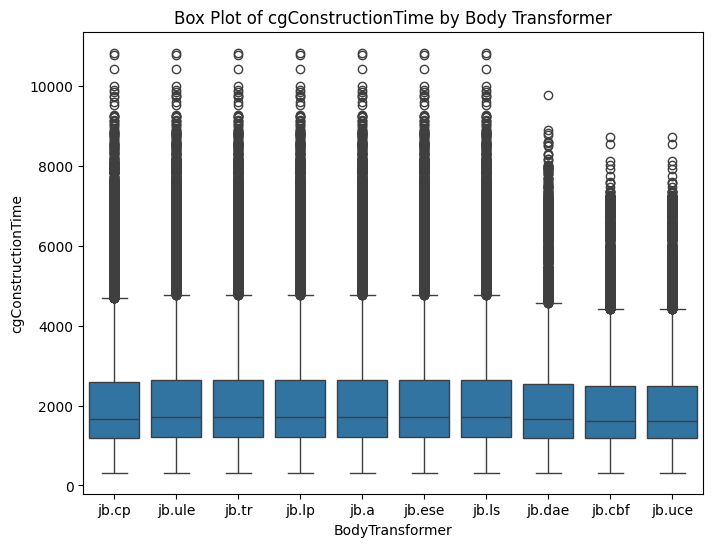

ANOVA Test Results:
                       df        sum_sq       mean_sq          F  \
BodyTransformer       9.0  1.150022e+09  1.277803e+08  62.506438   
Residual         387863.0  7.928981e+11  2.044274e+06        NaN   

                        PR(>F)  
BodyTransformer  2.755287e-115  
Residual                   NaN  
Tukey's HSD Results:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
  jb.a jb.cbf -157.5114    0.0 -193.4647 -121.5581   True
  jb.a  jb.cp  -42.6283 0.0016  -75.4469   -9.8098   True
  jb.a jb.dae -100.1932    0.0 -136.1465  -64.2399   True
  jb.a jb.ese       0.0    1.0  -29.3518   29.3518  False
  jb.a  jb.lp       0.0    1.0  -29.3518   29.3518  False
  jb.a  jb.ls       0.0    1.0  -29.3518   29.3518  False
  jb.a  jb.tr       0.0    1.0  -29.3518   29.3518  False
  jb.a jb.uce -157.5114    0.0 -193.4647 -121.5581   True
  jb.a jb.ule    

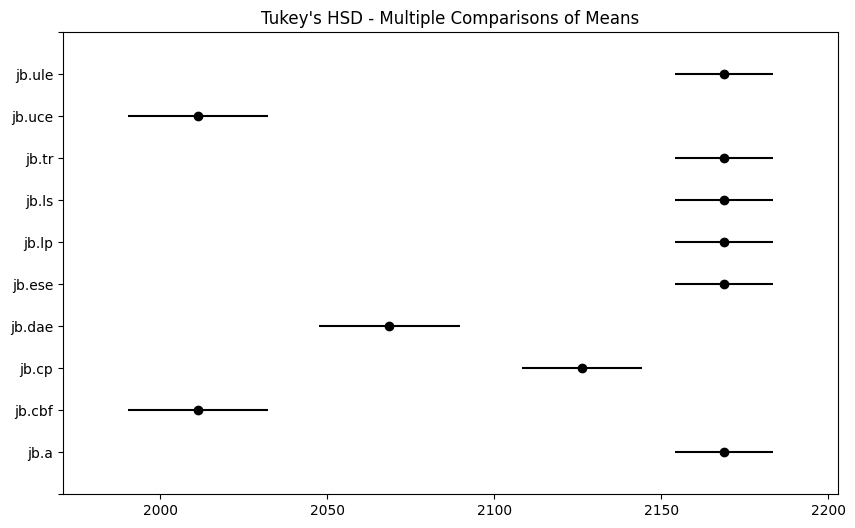

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


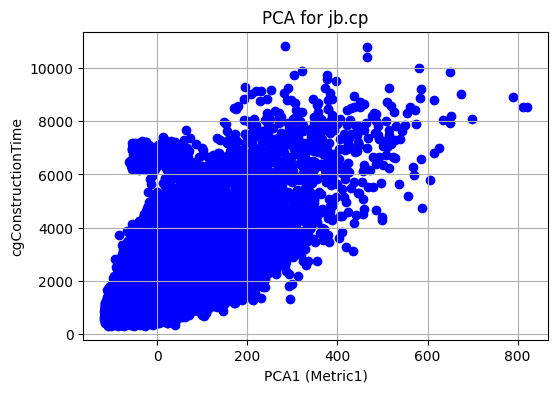

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


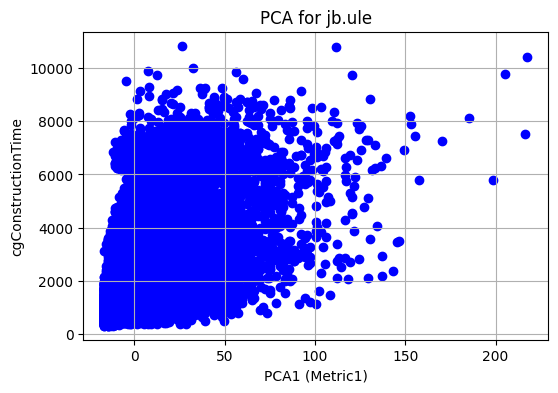

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


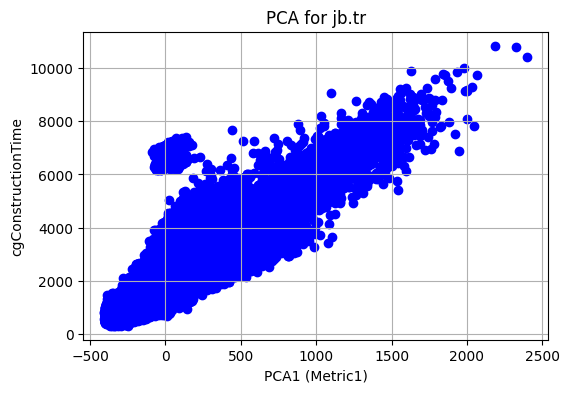

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


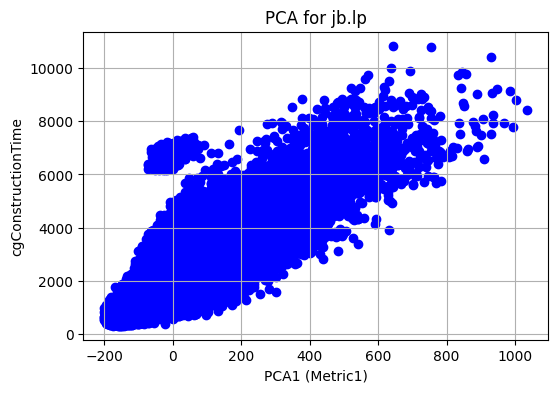

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


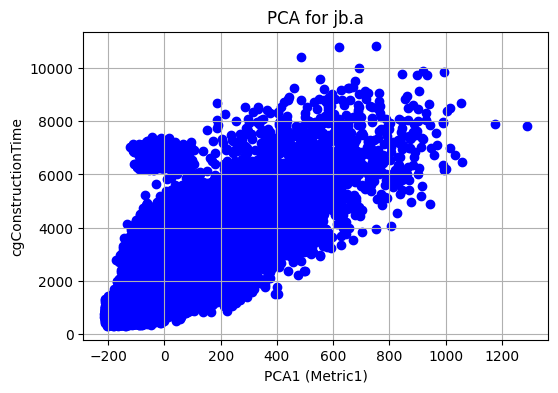

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


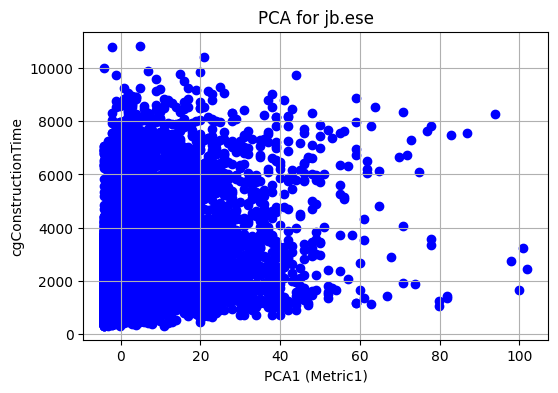

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


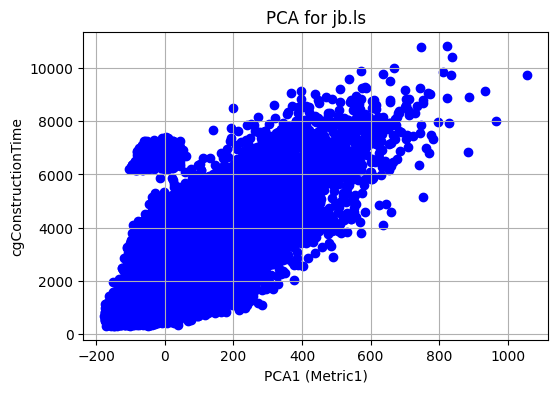

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


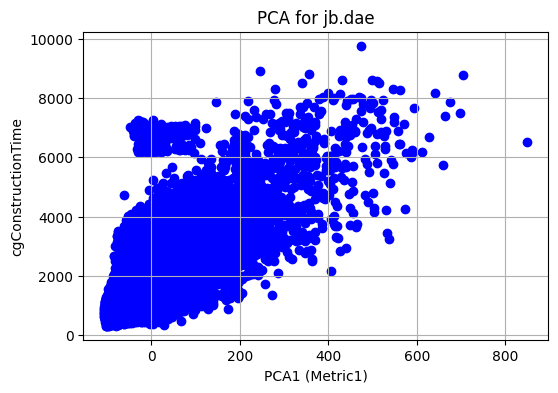

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


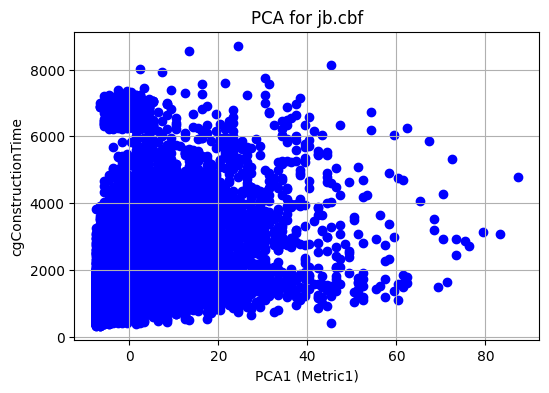

C:\Users\sahil\AppData\Local\Temp\ipykernel_8644\1627006737.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = principal_components[:, 0]


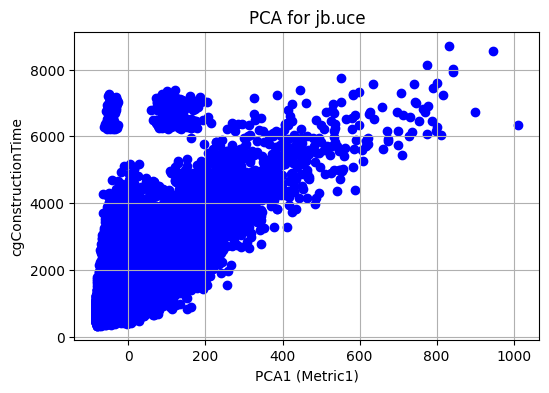

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA

# Create DataFrame
df = pd.DataFrame(data)

# Unroll 'BodyTransformersMetrics' into individual columns
def extract_transformers(df):
    rows = []
    for idx, row in df.iterrows():
        cg_time = row['cgConstructionTime']
        body_metrics = row['BodyTransformersMetrics']
        for transformer, values in body_metrics.items():
            rows.append({
                'cgConstructionTime': cg_time,
                'BodyTransformer': transformer,
                'Metric1': values[0],
                # 'Metric2': values[1]  # assuming there are two metrics in each
            })
    return pd.DataFrame(rows)

# Transform Data
df_unrolled = extract_transformers(df)

# List of unique body transformers
transformers_list = df_unrolled['BodyTransformer'].unique()

### BOX PLOT ###
plt.figure(figsize=(8,6))
sns.boxplot(x='BodyTransformer', y='cgConstructionTime', data=df_unrolled)
plt.title('Box Plot of cgConstructionTime by Body Transformer')
plt.show()

### ANOVA TEST ###
# Fit an OLS model and perform ANOVA
model = ols('cgConstructionTime ~ BodyTransformer', data=df_unrolled).fit()
anova_results = anova_lm(model)

print("ANOVA Test Results:")
print(anova_results)

### TUKEY'S HSD ###
# Perform Tukey's HSD test for multiple comparisons
tukey = pairwise_tukeyhsd(endog=df_unrolled['cgConstructionTime'], 
                          groups=df_unrolled['BodyTransformer'], 
                          alpha=0.05)

print("Tukey's HSD Results:")
print(tukey)

# Visualizing Tukey's HSD results
tukey.plot_simultaneous()
plt.title("Tukey's HSD - Multiple Comparisons of Means")
plt.show()


# Perform PCA and create individual plots for each body transformer
for transformer in transformers_list:
    # Filter the DataFrame for the current transformer
    df_filtered = df_unrolled[df_unrolled['BodyTransformer'] == transformer]
    
    # PCA requires at least two samples, so we'll check if we have enough data
    if len(df_filtered) > 1:
        # Select the 'Metric1' column for PCA (reshaping for single feature)
        X = df_filtered[['Metric1']].values.reshape(-1, 1)

        # Apply PCA
        pca = PCA(n_components=1)  # Only 1 component due to single feature
        principal_components = pca.fit_transform(X)
        
        # Add the principal component back to the DataFrame
        df_filtered['PCA1'] = principal_components[:, 0]

        # Create a plot for each body transformer
        plt.figure(figsize=(6, 4))
        plt.scatter(df_filtered['PCA1'], df_filtered['cgConstructionTime'], color='b')
        plt.title(f'PCA for {transformer}')
        plt.xlabel('PCA1 (Metric1)')
        plt.ylabel('cgConstructionTime')
        plt.grid(True)
        plt.show()
    else:
        print(f"Not enough data for PCA on {transformer} (requires at least 2 samples).")

# ### PRINCIPAL COMPONENT ANALYSIS (PCA) ###
# # We will use Metric1 and Metric2 for PCA
# # X = df_unrolled[['Metric1', 'Metric2']]
# X = df_unrolled[['Metric1']]

# # Apply PCA
# # pca = PCA(n_components=2)
# pca = PCA(n_components=1)
# principal_components = pca.fit_transform(X)

# # Add the principal components to the DataFrame
# df_unrolled['PCA1'] = principal_components[:, 0]
# # df_unrolled['PCA2'] = principal_components[:, 1]

# # Plot the PCA results
# plt.figure(figsize=(8,6))
# # sns.scatterplot(x='PCA1', y='PCA2', hue='BodyTransformer', data=df_unrolled)
# sns.scatterplot(x='PCA1', hue='BodyTransformer', data=df_unrolled)
# plt.title('PCA of Body Transformers Metrics')
# plt.show()


## LCP

# ================== IGNORE ======================

### BodyTransfomers Combination VS totaltime for LCP (CHA)

In [ ]:
import pandas as pd

# Sample data
data = {
    'totalRuntime': df_CHA['totalRuntime'].values.tolist(),
    'BodyTransformers':  df_CHA['BodyTransformers'].values.tolist()
}

# Create a DataFrame
df_bi_lcp = pd.DataFrame(data)

# Explode the BodyTransformers list to create one row per transformer
df_exploded_bi_lcp = df_bi_lcp.explode('BodyTransformers')
print(df_exploded_bi_lcp)

# Group by BodyTransformer and calculate the mean totalRuntime for each transformer
transformer_runtime = df_exploded_bi_lcp.groupby('BodyTransformers')['totalRuntime'].mean()

# Display the result
print(transformer_runtime)

# Plot the results
plt.figure(figsize=(20, 10))
transformer_runtime.plot(kind='bar', color='orange')

plt.xticks(ticks=range(len(transformer_runtime)), labels=transformer_runtime.index, rotation=90)
plt.title('Average Total Runtime for Each BodyTransformer')
plt.xlabel('BodyTransformer')
plt.ylabel('Average Total Runtime')
plt.tight_layout()

# Show the plot
plt.show()


### BodyTransfomers Combination VS Stmt Count (CHA)

In [ ]:
df_CHA.head()
df1 = df_CHA[['initialStmtCount', 'stmtCountAfterApplyingBI', 'BodyTransformers']]
df1.iloc[90:120]
print('\n'.join(lines[:15]))

In [ ]:
df_CHA['stmtChange'] = df_CHA['initialStmtCount'] - df_CHA['stmtCountAfterApplyingBI']
df_CHA['stmtChange'] = df_CHA['stmtChange'].abs()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'stmtChange': df_CHA['stmtChange'].values.tolist(),
    'BodyTransformers':  df_CHA['BodyTransformers'].values.tolist()
}

# Create a DataFrame
df_bi_stmts = pd.DataFrame(data)

# Explode the BodyTransformers list to create one row per transformer
df_exploded_bi_stmts = df_bi_stmts.explode('BodyTransformers')
print(df_exploded_bi_stmts)

# Group by BodyTransformer and calculate the mean totalRuntime for each transformer
transformer_stmtChange = df_exploded_bi_stmts.groupby('BodyTransformers')['stmtChange'].mean()

# Display the result
print(transformer_stmtChange)

# Plot the results
plt.figure(figsize=(20, 10))
transformer_stmtChange.plot(kind='bar', color='skyblue')

plt.xticks(ticks=range(len(transformer_stmtChange)), labels=transformer_runtime.index, rotation=90)
plt.title('Average Statement Change for Each BodyTransformer')
plt.xlabel('BodyTransformer')
plt.ylabel('Average Statement Change')
plt.tight_layout()

# Show the plot
plt.show()


### Relationship between `Each BodyTransformer` and the `totalRuntime` using Correlation

In [6]:
# Import necessary libraries
import pandas as pd
import ast
 
# Sample data as provided
data = {
    'totalRuntime': df['totalRuntime'].values.tolist(),
    'BodyTransformersMetrics': df['BodyTransformersMetrics'].values.tolist()
}
 
# Create dataframe
df_1 = pd.DataFrame(data)
 
# Function to convert BodyTransformersMetrics string to a dictionary
def parse_body_transformers_metrics(metrics_str):
    return ast.literal_eval(metrics_str)
 
# Apply the function to parse the BodyTransformersMetrics column
df_1['BodyTransformersMetrics'] = df_1['BodyTransformersMetrics'].apply(parse_body_transformers_metrics)
 
# Extract individual BodyTransformers and their corresponding time taken
for index, row in df_1.iterrows():
    for transformer, metrics in row['BodyTransformersMetrics'].items():
        # Create a new column for each transformer and fill it with the time taken (first element of the list)
        df_1.at[index, transformer] = metrics[0]
 
# Drop the original 'BodyTransformersMetrics' column since it's no longer needed
df_1.drop(columns=['BodyTransformersMetrics'], inplace=True)
 
# Now let's analyze the relationship between each BodyTransformer and the totalRuntime
# Calculate the correlation matrix to find relationships between the columns
correlation_matrix = df_1.corr()
 
# Display the correlation matrix
correlation_matrix

,totalRuntime,jb.tr,jb.ls,jb.lp,jb.ese,jb.ne,jb.dae,jb.ule,jb.cp,jb.uce,jb.tt,jb.lns,jb.cbf,jb.dtr,jb.sils,jb.a,jb.ulp,jb.cp-ule
totalRuntime,1.000000,0.889877,0.863742,0.935439,0.895910,0.855858,0.958077,0.862117,0.933798,0.835201,0.917655,0.865239,0.879155,0.930109,0.967457,0.963944,0.932531,0.499258
jb.tr,0.889877,1.000000,0.979806,0.988822,0.906216,0.944131,0.990723,0.929102,0.996991,0.885695,0.958729,0.960542,0.948717,0.901748,0.987161,0.977293,0.982517,0.658513
jb.ls,0.863742,0.979806,1.000000,0.984793,0.928181,0.943335,0.982821,0.876573,0.991922,0.845287,0.968565,0.978366,0.954938,0.897047,0.987068,0.983104,0.991677,0.640039
jb.lp,0.935439,0.988822,0.984793,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.ese,0.895910,0.906216,0.928181,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.ne,0.855858,0.944131,0.943335,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.dae,0.958077,0.990723,0.982821,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.ule,0.862117,0.929102,0.876573,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.cp,0.933798,0.996991,0.991922,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.uce,0.835201,0.885695,0.845287,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_1.head

<bound method NDFrame.head of      totalRuntime   jb.tr   jb.ls   jb.lp  jb.ese  jb.ne  jb.dae  jb.ule  \
0          157630  3019.0  1855.0     NaN     NaN    NaN     NaN     NaN   
1           96568  2878.0  1520.0  1443.0     NaN    NaN     NaN     NaN   
2          138687  2947.0  1641.0     NaN    94.0    NaN     NaN     NaN   
3          137373  3880.0  2046.0     NaN     NaN  103.0     NaN     NaN   
4          131336  3015.0  1596.0     NaN     NaN    NaN  1080.0     NaN   
..            ...     ...     ...     ...     ...    ...     ...     ...   
956        139934  2128.0  1167.0     NaN     NaN    NaN     NaN     NaN   
957        132484  1949.0   836.0     NaN     NaN    NaN     NaN     NaN   
958        142220  2251.0   969.0     NaN     NaN    NaN     NaN     NaN   
959        124781  2109.0   944.0     NaN     NaN    NaN     NaN     NaN   
960        123916  1948.0  1102.0     NaN     NaN    NaN     NaN     NaN   

     jb.cp  jb.uce  jb.tt  jb.lns  jb.cbf  jb.dtr  jb.sil

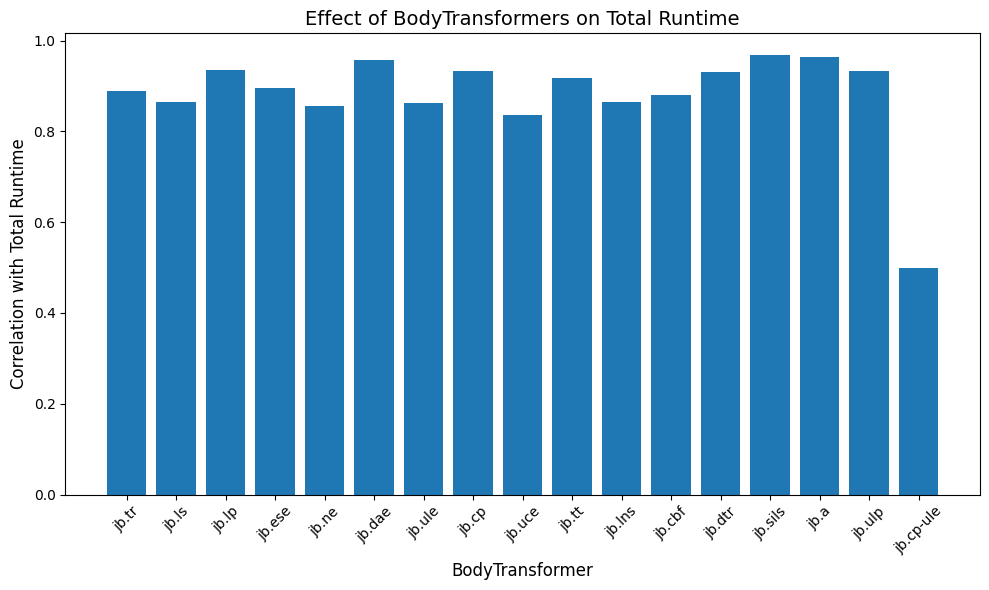

In [10]:
'''
To visualize the impact of each BodyTransformer on the total runtime, we can compute a metric that captures the effect of each BodyTransformer 
on the total time taken. For this analysis, we can use the correlation values between each BodyTransformer's time and the total runtime as a 
measure of effect. We will then create a bar plot with the BodyTransformers on the x-axis and their corresponding effect on the y-axis.
'''

'''- **Y-axis**: Correlation between each BodyTransformer's time and the `totalRuntime`. The correlation is a metric that indicates how much the time spent on a specific BodyTransformer is related to the total runtime.
  - Positive correlation means that as the time taken by a BodyTransformer increases, the total runtime tends to increase.
  - Negative correlation suggests the opposite.
 
This graph will help visualize which BodyTransformer has the most significant effect (either positively or negatively) on the total runtime.'''


# We already have the correlation matrix from previous steps
# Extract the correlation values between totalRuntime and each BodyTransformer
correlation_with_runtime = correlation_matrix['totalRuntime'].drop('totalRuntime')
 
# Plot the effect of each BodyTransformer on the totalRuntime
plt.figure(figsize=(10, 6))
plt.bar(correlation_with_runtime.index, correlation_with_runtime.values)
plt.title('Effect of BodyTransformers on Total Runtime', fontsize=14)
plt.xlabel('BodyTransformer', fontsize=12)
plt.ylabel('Correlation with Total Runtime', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
 
# Show the plot
plt.show()


### Relationship between Each BodyTransformer and the totalRuntime using ANOVA

In [11]:
'''We will use **ANOVA** (since you have more than two BodyTransformers) to check if some of the BodyTransformers are making the total 
runtime significantly different.'''

'''### Explanation of the ANOVA Code:
1. We look at all the **BodyTransformers** (e.g., `jb.tr`, `jb.ls`) and grab the time taken for each.
2. We run an **ANOVA test** to check if there’s any significant difference between the transformers.
3. The output gives us an **F-statistic** and a **p-value**.
   - **F-statistic**: Tells us how big the difference is.
   - **p-value**: If this is less than 0.05, we say, "Yes! Some transformers really affect the total time!"
 
### What's Next:
- If the **p-value** is less than 0.05, we can conclude that **some BodyTransformers significantly affect the total runtime** more than others.
- If it's greater than 0.05, we would say the BodyTransformers are **not significantly different** from each other.'''

from scipy import stats
 
# Prepare the data for ANOVA test
# Extracting times for each BodyTransformer (e.g., jb.tr, jb.ls, etc.)
transformers = [col for col in df_1.columns if col != 'totalRuntime']
 
# Perform one-way ANOVA test
anova_result = stats.f_oneway(*[df_1[transformer].dropna() for transformer in transformers])
 
# Display the result
anova_result

# F_onewayResult(statistic=np.float64(14.524264603558748), pvalue=np.float64(1.1636712085756704e-38))

F_onewayResult(statistic=np.float64(14.524264603558748), pvalue=np.float64(1.1636712085756704e-38))

### Relationship between Each BodyTransformer and the totalRuntime using Regression analysis

In [5]:
'''
Regression analysis will help us understand how much each `BodyTransformer` affects the total runtime. Specifically, we'll perform a 
**multiple linear regression**, where the `totalRuntime` will be our dependent variable, and the times taken by each `BodyTransformer` 
will be the independent variables.

### Explanation of the Code:
 
1. **Independent Variables (X)**: These are the columns that represent the time taken by each `BodyTransformer`. We drop the `totalRuntime` column since it’s the dependent variable.
2. **Dependent Variable (y)**: This is the `totalRuntime` column, which we are trying to predict based on the time taken by each `BodyTransformer`.
3. **Add Constant**: This step adds an intercept (a baseline value) to the model.
4. **OLS (Ordinary Least Squares) Model**: We fit a linear regression model using the independent variables to predict `totalRuntime`.
5. **Model Summary**: The `summary()` function provides key outputs such as:
   - **Coefficients**: These tell us how much each `BodyTransformer` affects the total runtime.
   - **p-values**: If the p-value for a `BodyTransformer` is less than 0.05, it means that the time taken by that `BodyTransformer` significantly affects the total runtime.
   - **R-squared**: This tells us how well the independent variables explain the variation in `totalRuntime`. The closer this value is to 1, the better the model.
 
### Understanding the Results:
 
- **Coefficients**: These show how much the `totalRuntime` will change when the time for a specific `BodyTransformer` increases by one unit. A positive value means an increase in time increases the `totalRuntime`, while a negative value means it decreases the `totalRuntime`.
- **p-value**: If the p-value is small (typically less than 0.05), it means that the corresponding `BodyTransformer` has a significant effect on the total runtime.
- **R-squared**: This tells us how much of the variation in `totalRuntime` is explained by the time taken by the BodyTransformers. The closer this value is to 1, the better the fit.
 
### Next Steps:
Once you run this code, you’ll get insights into:
- Which BodyTransformers significantly affect the total runtime.
- How much each BodyTransformer impacts the total runtime.
'''
import pandas as pd
import statsmodels.api as sm
 
# Assuming df is already created as per the previous steps and each BodyTransformer has its column with time
# We will use the time for each transformer to predict totalRuntime
 
# Extract independent variables (BodyTransformers) and dependent variable (totalRuntime)
df_new = df_1.copy()
df_new.head()

X = df_new['BodyTransformersMetrics']
y = df_new['totalRuntime']
 
# Add a constant to the model (for the intercept)
X = sm.add_constant(X)
 
# Fit the regression model
model = sm.OLS(y, X).fit()
 
# Print out the regression results
print(model.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

### ======================== Graphs Not Useful in Eval_Main =======================